# Трансформеры принятия решений и заключение
Задача: провести эксперименты с алгоритмами автономного обучения с подкреплением в среде Pogema.

**Улучшение сходимости алгоритма:**

Добавьте wrapper, который будет выдавать агенту плотную награду за выполнение действий. К примеру пропорциональную изменению расстоянию от агента до цели.
## Исследование алгоритмов на данных с оптимальной стратегией:

- Использовать датасет с оптимальной стратегией поведения, полученной путем обучения online RL алгоритма.
- Обучить агентов, используя алгоритмы CQL и DT из фреймворка d3rlpy.
- Сравнить результаты с алгоритмом BC.

## Работа с субоптимальной стратегией:

- Сгенерировать датасет с субоптимальной стратегией с использованием библиотеки d3rlpy: добавить в датасет с хорошей стратегией обучения данные со случайной стратегией обучения.
- Обучить агентов, используя алгоритмы CQL и DT из фреймворка d3rlpy.
- Сравнить результаты с алгоритмом BC.

**Что нужно сдать:**
- Код обучения в формате Jupyter.
- Графики сходимости (среднее вознаграждение) для всех исследованных алгоритмов.
- Выводы по используемым по обучению агента на оптимальных и неоптимальных данных.

In [8]:
%pip install pogema
%pip install d3rlpy

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip


## Шаг 1. Загрузим среду

Загрузим среду pogema (статья "POGEMA: Partially Observable Grid Environment for Multiple Agents" https://arxiv.org/abs/2206.10944, код https://github.com/AIRI-Institute/pogema , документация библиотеки https://pypi.org/project/pogema/)

Для этой среды подгтовила обертку CustomReward, основная задача которой штрафовать агента, если он находится на в окрестности одной клетки от цели. В таком случае расстояние между агентом и целью будет больше 1,5. Если агент ниже или выше, правее или левее цели на одну клетку, то расстояние == 1. Если по диагонали, то 1,4.
Вторая обертка из ноутбука, представленного на занятии, для преобразования наблюдения в одномерный вектор, чтобы можно было использовать в библиотеке d3rlpy.

Инициирую среду в той конфигруации, что указано в задании. Единственное, выберу random_seed = 2. При таком seed немного интереснее интерфейс.

В конце выведу 3 примера на экран, чтобы проверить как работают обертки.

In [6]:
import numpy as np
import gym
from pogema import pogema_v0, GridConfig
import warnings
warnings.filterwarnings("ignore")


class VectorObservationAndActionWrapper(gym.Wrapper):
    def __init__(self, env):
        super(VectorObservationAndActionWrapper, self).__init__(env)
        self.action_space = env.action_space
        obs_space = env.observation_space
        size = obs_space.shape
        new_size = 1*size[1]*size[2]
        self.observation_space = gym.spaces.Box(low=np.zeros((new_size)),
                                                high=np.ones((new_size)),
                                                shape = (new_size,),
                                                dtype=obs_space.dtype)


    def reset(self):
        observation, is_active = self.env.reset()
        return observation[0][0].flatten(), is_active  # Возвращает наблюдение как одномерный вектор

    def step(self, action):
        # Упаковка действия в массив
        obs, reward, trancated, terminated, info = self.env.step([action])

        # Распаковка наблюдения, награды и флага завершения
        return obs[0][0].flatten(), reward[0],  trancated[0], terminated[0], info[0]


class CustomReward(gym.Wrapper):
    def __init__(self, env):
        super(CustomReward, self).__init__(env)

    def step(self, action):
        obs, reward, truncated, terminated, info = self.env.step(action)
        target_coordinates = env.get_targets_xy()
        agent_coordinates = env.get_agents_xy()
        distance_to_target = ((agent_coordinates[0][0] - target_coordinates[0][0])**2 + (agent_coordinates[0][1] - target_coordinates[0][1])**2)**1/2
        if distance_to_target > 1.5:
          reward -=0.1

        return  obs, reward, truncated, terminated, info

    def reset(self):
        """Reset the environment and return the initial observation."""
        return self.env.reset()

# Определение конфигурации среды
grid_config = GridConfig(num_agents=1,  # количество агентов
                         size=15,  # размер сетки
                         density=0.4,  # плотность препятствий
                         seed=2,  # зерно для генерации
                         max_episode_steps=128,  # горизонт планирования
                         obs_radius=3,  # радиус видимости
                         )

# Создание среды и обертывание ее
env = pogema_v0(grid_config=grid_config)
env = VectorObservationAndActionWrapper(env)
env = CustomReward(env)

# Тестирование среды
obs = env.reset()
print("Начальное наблюдение в виде вектора:", len(obs[0]))

for _ in range(3):
    action = env.action_space.sample()  # Выбор случайного действия
    obs, reward, trancated, terminated, info = env.step(action)
    done =  trancated | terminated
    env.render()
    print(f"Наблюдение: {obs}, Награда: {reward}, Завершено: {done}, Положение агента {env.get_agents_xy()}, Положение цели {env.get_targets_xy()}, action {action}")
    if done:
        break


Начальное наблюдение в виде вектора: 49
 .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  . 
 .  .                                                     .  . 
 .  .     .  .     .        .  .  .     .  .  .     .     .  . 
 .  .              .  .  .  .        .     .     .  .     .  . 
 .  .     .              .  .  .     .           .        .  . 
 .  .     .  .  .  .  .     .        .     .     .  .     .  . 
 .  .     .  .     .  .     .  .  .     .        .        .  . 
 .  .     .     .     .  .  .        .  .  .     .  .     .  . 
 .  .        . |0| .  .  .  .  .  .  .  .  .     .        .  . 
 .  .        .  .  .     .  .  .              .           .  . 
 .  .     .  .     .  .        .     .           .        .  . 
 .  .     .     .  .  .  .  .        .  .  .     .        .  . 
 .  .        .     .     .  .  .           .  .  .  .     .  . 
 .  .                 .  .  .  .        .  .     .        .  . 


Вроде бы все работает, можно приступать к основной части задания. Единственное, для отрисовки графиков обучения возьму функцию с семинара.

In [4]:
import matplotlib.pyplot as plt


def plot_metrics(statistics, label):
  epochs = []
  returns = []
  for stats in statistics:
    epoch = stats[0]
    metrics = stats[1]
    env_return = metrics['environment']
    epochs.append(epoch)
    returns.append(env_return)
  plt.plot(epochs, returns, label = label)


def get_scores(data):
  result = []
  for i in range(len(data)):
    result.append([scores[1]['environment'] for scores in data[i]])
  return np.array(result)

def visualize_with_std(data, proportions, label="default"):
  # Расчет средних значений и стандартных отклоненийt
  means = {p: np.mean(get_scores(data[p]), axis=0) for p in proportions}
  stds = {p: np.std(get_scores(data[p]), axis=0) for p in proportions}


  for p in proportions:
      x = np.arange(1, len(means[p]) + 1)
      plt.plot(x, means[p], label=f'{label} - Mean of {p}')
      plt.fill_between(x, means[p] - stds[p], means[p] + stds[p], alpha=0.2)

  plt.title('Сравнение обучения на данных разного качества')

# Обучение off-line на эталонных данных

Как предлагали на занятии, в качестве эталонных данных будем использовать буфер состояний, собранный во время Q-обучения. Для этого воспользуюсь алгоритмом DQN из библиотеки d3rlpy. Все параметры возьму стандартные, установлю величину буфера == 100 000. В процессе обучения агента собираются данные по rollout-return, график по изменению этой величины после обучения.

## Сбор эталонных данных

In [7]:
import d3rlpy
# setup algorithm
dqn = d3rlpy.algos.DQNConfig().create(device="cuda:0")

# prepare experience replay buffer
dqn_buffer = d3rlpy.dataset.create_fifo_replay_buffer(limit=100000, env=env)

# prepare exploration strategy if necessary
explorer = d3rlpy.algos.ConstantEpsilonGreedy(0.4)

# start data collection
dqn.fit_online(env, dqn_buffer, explorer, n_steps=150000, n_steps_per_epoch=5000)


2024-04-13 14:58.12 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('float32')], shape=[(49,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2024-04-13 14:58.12 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2024-04-13 14:58.12 [info     ] Action size has been automatically determined. action_size=5
2024-04-13 14:58.12 [info     ] Directory is created at d3rlpy_logs/DQN_online_20240413145812
2024-04-13 14:58.12 [debug    ] Building model...             
2024-04-13 14:58.12 [debug    ] Model has been built.         
2024-04-13 14:58.12 [info     ] Parameters                     params={'observation_shape': [49], 'action_size': 5, 'config': {'type': 'dqn', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}

  3%|▎         | 4996/150000 [00:18<08:42, 277.53it/s]

2024-04-13 14:58.30 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20240413145812/model_5000.d3
2024-04-13 14:58.30 [info     ] DQN_online_20240413145812: epoch=1 step=5000 epoch=1 metrics={'time_inference': 0.0003868335723876953, 'time_environment_step': 7.203855514526367e-05, 'time_step': 0.0035748799800872804, 'time_sample_batch': 0.0009505714188405438, 'time_algorithm_update': 0.002133031474144761, 'loss': 2.293011362416742e-05, 'rollout_return': -12.515384615384582} step=5000


  7%|▋         | 9983/150000 [00:36<08:36, 270.88it/s]

2024-04-13 14:58.49 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20240413145812/model_10000.d3
2024-04-13 14:58.49 [info     ] DQN_online_20240413145812: epoch=2 step=10000 epoch=2 metrics={'time_inference': 0.00038848767280578615, 'time_environment_step': 7.161054611206055e-05, 'time_sample_batch': 0.0009701768398284913, 'time_algorithm_update': 0.0021466802597045896, 'loss': 2.6527594110871978e-05, 'time_step': 0.0036297518730163576, 'rollout_return': -12.799999999999967} step=10000


 10%|▉         | 14987/150000 [00:54<08:19, 270.15it/s]

2024-04-13 14:59.07 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20240413145812/model_15000.d3
2024-04-13 14:59.07 [info     ] DQN_online_20240413145812: epoch=3 step=15000 epoch=3 metrics={'time_inference': 0.00038834686279296877, 'time_environment_step': 7.163281440734863e-05, 'time_sample_batch': 0.0009861636638641357, 'time_algorithm_update': 0.0021415894985198974, 'loss': 1.0103847739590189e-05, 'time_step': 0.0036407545566558837, 'rollout_return': -12.682499999999965} step=15000


 13%|█▎        | 19974/150000 [01:12<07:51, 275.92it/s]

2024-04-13 14:59.25 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20240413145812/model_20000.d3
2024-04-13 14:59.25 [info     ] DQN_online_20240413145812: epoch=4 step=20000 epoch=4 metrics={'time_inference': 0.00038503484725952147, 'time_environment_step': 7.12893009185791e-05, 'time_sample_batch': 0.0009852318286895751, 'time_algorithm_update': 0.0021265015602111815, 'loss': 9.201531867528097e-05, 'time_step': 0.003620987272262573, 'rollout_return': -11.97499999999997} step=20000


 17%|█▋        | 24985/150000 [01:31<07:39, 272.32it/s]

2024-04-13 14:59.44 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20240413145812/model_25000.d3
2024-04-13 14:59.44 [info     ] DQN_online_20240413145812: epoch=5 step=25000 epoch=5 metrics={'time_inference': 0.00038670468330383303, 'time_environment_step': 7.164692878723145e-05, 'time_sample_batch': 0.0009969273567199707, 'time_algorithm_update': 0.0021207821369171142, 'loss': 7.794330436148904e-05, 'time_step': 0.003630900859832764, 'rollout_return': -11.372093023255784} step=25000


 20%|█▉        | 29994/150000 [01:49<07:24, 269.73it/s]

2024-04-13 15:00.02 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20240413145812/model_30000.d3
2024-04-13 15:00.02 [info     ] DQN_online_20240413145812: epoch=6 step=30000 epoch=6 metrics={'time_inference': 0.00038671507835388185, 'time_environment_step': 7.212738990783692e-05, 'time_sample_batch': 0.001008333969116211, 'time_algorithm_update': 0.002121877431869507, 'loss': 4.250077626753779e-05, 'time_step': 0.003643826484680176, 'rollout_return': -11.53720930232555} step=30000


 23%|██▎       | 34994/150000 [02:08<07:04, 270.73it/s]

2024-04-13 15:00.21 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20240413145812/model_35000.d3
2024-04-13 15:00.21 [info     ] DQN_online_20240413145812: epoch=7 step=35000 epoch=7 metrics={'time_inference': 0.0003878791332244873, 'time_environment_step': 7.161407470703125e-05, 'time_sample_batch': 0.0010138744354248046, 'time_algorithm_update': 0.0021147113800048826, 'loss': 0.00015141980204382222, 'time_step': 0.0036464755058288572, 'rollout_return': -8.955999999999982} step=35000


 27%|██▋       | 39998/150000 [02:26<06:46, 270.90it/s]

2024-04-13 15:00.39 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20240413145812/model_40000.d3
2024-04-13 15:00.39 [info     ] DQN_online_20240413145812: epoch=8 step=40000 epoch=8 metrics={'time_inference': 0.00038477587699890136, 'time_environment_step': 7.146258354187011e-05, 'time_sample_batch': 0.001018436050415039, 'time_algorithm_update': 0.002109010553359985, 'loss': 2.9976049969279473e-05, 'time_step': 0.003649980592727661, 'rollout_return': -6.544615384615373} step=40000


 30%|██▉       | 44991/150000 [02:45<06:25, 272.43it/s]

2024-04-13 15:00.58 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20240413145812/model_45000.d3
2024-04-13 15:00.58 [info     ] DQN_online_20240413145812: epoch=9 step=45000 epoch=9 metrics={'time_inference': 0.0003897488594055176, 'time_environment_step': 7.196435928344726e-05, 'time_sample_batch': 0.0010340410709381103, 'time_algorithm_update': 0.002115999412536621, 'loss': 0.00019449697487617073, 'time_step': 0.003665871286392212, 'rollout_return': -12.357499999999968} step=45000


 33%|███▎      | 49978/150000 [03:03<06:09, 270.87it/s]

2024-04-13 15:01.16 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20240413145812/model_50000.d3
2024-04-13 15:01.16 [info     ] DQN_online_20240413145812: epoch=10 step=50000 epoch=10 metrics={'time_inference': 0.00038692336082458495, 'time_environment_step': 7.147092819213867e-05, 'time_sample_batch': 0.0010374167919158935, 'time_algorithm_update': 0.0021214181423187257, 'loss': 0.00011707689232145242, 'time_step': 0.0036725656032562254, 'rollout_return': -10.990909090909064} step=50000


 37%|███▋      | 54982/150000 [03:22<06:08, 257.92it/s]

2024-04-13 15:01.35 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20240413145812/model_55000.d3
2024-04-13 15:01.35 [info     ] DQN_online_20240413145812: epoch=11 step=55000 epoch=11 metrics={'time_inference': 0.000388311243057251, 'time_environment_step': 7.205896377563476e-05, 'time_sample_batch': 0.0010464236736297608, 'time_algorithm_update': 0.0021196670532226563, 'loss': 1.1253043580659039e-05, 'time_step': 0.003681575918197632, 'rollout_return': -11.03409090909088} step=55000


 40%|███▉      | 59981/150000 [03:41<05:38, 265.79it/s]

2024-04-13 15:01.54 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20240413145812/model_60000.d3
2024-04-13 15:01.54 [info     ] DQN_online_20240413145812: epoch=12 step=60000 epoch=12 metrics={'time_inference': 0.0003872288703918457, 'time_environment_step': 7.187342643737793e-05, 'time_sample_batch': 0.0010559017181396484, 'time_algorithm_update': 0.0021227744579315187, 'loss': 0.00015503378057517522, 'time_step': 0.0037370726108551027, 'rollout_return': -2.1713178294573616} step=60000


 43%|████▎     | 64979/150000 [04:00<05:33, 255.05it/s]

2024-04-13 15:02.13 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20240413145812/model_65000.d3
2024-04-13 15:02.13 [info     ] DQN_online_20240413145812: epoch=13 step=65000 epoch=13 metrics={'time_inference': 0.00038935403823852537, 'time_environment_step': 7.251734733581543e-05, 'time_sample_batch': 0.0010777344703674315, 'time_algorithm_update': 0.002180746650695801, 'loss': 0.00011362757023364054, 'time_step': 0.0038393639087677, 'rollout_return': -1.5614457831325297} step=65000


 47%|████▋     | 69974/150000 [04:20<05:17, 252.43it/s]

2024-04-13 15:02.33 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20240413145812/model_70000.d3
2024-04-13 15:02.33 [info     ] DQN_online_20240413145812: epoch=14 step=70000 epoch=14 metrics={'time_inference': 0.00039119982719421385, 'time_environment_step': 7.253470420837402e-05, 'time_sample_batch': 0.0010897173881530761, 'time_algorithm_update': 0.0022181233882904053, 'loss': 2.1505646560119373e-05, 'time_step': 0.003919071960449219, 'rollout_return': -0.7563063063063067} step=70000


 50%|████▉     | 74989/150000 [04:40<04:49, 258.72it/s]

2024-04-13 15:02.52 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20240413145812/model_75000.d3
2024-04-13 15:02.52 [info     ] DQN_online_20240413145812: epoch=15 step=75000 epoch=15 metrics={'time_inference': 0.0003913118362426758, 'time_environment_step': 7.241106033325195e-05, 'time_sample_batch': 0.0011054612636566161, 'time_algorithm_update': 0.002206409025192261, 'loss': 0.0001622520664291244, 'time_step': 0.003914369583129883, 'rollout_return': -0.8307317073170738} step=75000


 53%|█████▎    | 79978/150000 [04:59<04:35, 254.24it/s]

2024-04-13 15:03.12 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20240413145812/model_80000.d3
2024-04-13 15:03.12 [info     ] DQN_online_20240413145812: epoch=16 step=80000 epoch=16 metrics={'time_inference': 0.00038778367042541505, 'time_environment_step': 7.25346565246582e-05, 'time_sample_batch': 0.0011022790908813476, 'time_algorithm_update': 0.002126005697250366, 'loss': 1.0955194819922553e-05, 'time_step': 0.003840214443206787, 'rollout_return': -0.7186956521739132} step=80000


 57%|█████▋    | 84977/150000 [05:18<04:15, 254.87it/s]

2024-04-13 15:03.31 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20240413145812/model_85000.d3
2024-04-13 15:03.31 [info     ] DQN_online_20240413145812: epoch=17 step=85000 epoch=17 metrics={'time_inference': 0.00038646440505981446, 'time_environment_step': 7.203965187072754e-05, 'time_sample_batch': 0.0011372207164764404, 'time_algorithm_update': 0.0021202809810638426, 'loss': 0.0001455141901721504, 'time_step': 0.003862299966812134, 'rollout_return': -0.7633484162895925} step=85000


 60%|█████▉    | 89984/150000 [05:38<03:53, 257.32it/s]

2024-04-13 15:03.51 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20240413145812/model_90000.d3
2024-04-13 15:03.51 [info     ] DQN_online_20240413145812: epoch=18 step=90000 epoch=18 metrics={'time_inference': 0.00038820457458496095, 'time_environment_step': 7.319993972778321e-05, 'time_sample_batch': 0.0011375689506530763, 'time_algorithm_update': 0.002128882646560669, 'loss': 0.00023552973991792497, 'time_step': 0.0038796091079711915, 'rollout_return': -0.7030434782608699} step=90000


 63%|██████▎   | 94976/150000 [05:58<03:34, 256.56it/s]

2024-04-13 15:04.11 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20240413145812/model_95000.d3
2024-04-13 15:04.11 [info     ] DQN_online_20240413145812: epoch=19 step=95000 epoch=19 metrics={'time_inference': 0.000388743257522583, 'time_environment_step': 7.26719856262207e-05, 'time_sample_batch': 0.001147619342803955, 'time_algorithm_update': 0.0021289031505584716, 'loss': 1.1926094655426312e-05, 'time_step': 0.0038916773319244385, 'rollout_return': -0.7226495726495727} step=95000


 67%|██████▋   | 99976/150000 [06:17<03:17, 253.04it/s]

2024-04-13 15:04.30 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20240413145812/model_100000.d3
2024-04-13 15:04.30 [info     ] DQN_online_20240413145812: epoch=20 step=100000 epoch=20 metrics={'time_inference': 0.00038930606842041014, 'time_environment_step': 7.315130233764649e-05, 'time_sample_batch': 0.0011659354209899902, 'time_algorithm_update': 0.002140138101577759, 'loss': 0.00014605795927533904, 'time_step': 0.003918172883987427, 'rollout_return': -0.7408888888888886} step=100000


 70%|██████▉   | 104981/150000 [06:38<03:06, 241.70it/s]

2024-04-13 15:04.51 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20240413145812/model_105000.d3
2024-04-13 15:04.51 [info     ] DQN_online_20240413145812: epoch=21 step=105000 epoch=21 metrics={'time_inference': 0.0003943510055541992, 'time_environment_step': 7.378582954406739e-05, 'time_sample_batch': 0.0011847120761871337, 'time_algorithm_update': 0.0021747013092041014, 'loss': 5.057347644314092e-05, 'time_step': 0.003983865451812744, 'rollout_return': -0.7059829059829058} step=105000


 73%|███████▎  | 109987/150000 [06:58<02:39, 250.35it/s]

2024-04-13 15:05.11 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20240413145812/model_110000.d3
2024-04-13 15:05.11 [info     ] DQN_online_20240413145812: epoch=22 step=110000 epoch=22 metrics={'time_inference': 0.00039571561813354493, 'time_environment_step': 7.398509979248046e-05, 'time_sample_batch': 0.0011915568351745605, 'time_algorithm_update': 0.0022366758346557616, 'loss': 6.807826112594739e-06, 'time_step': 0.004056316995620727, 'rollout_return': -0.6953781512605038} step=110000


 77%|███████▋  | 114978/150000 [07:18<02:16, 256.03it/s]

2024-04-13 15:05.31 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20240413145812/model_115000.d3
2024-04-13 15:05.31 [info     ] DQN_online_20240413145812: epoch=23 step=115000 epoch=23 metrics={'time_inference': 0.00038922686576843264, 'time_environment_step': 7.278928756713868e-05, 'time_sample_batch': 0.0011761135578155517, 'time_algorithm_update': 0.00214176983833313, 'loss': 2.0698754549090382e-05, 'time_step': 0.003930432748794556, 'rollout_return': -0.7626666666666667} step=115000


 80%|███████▉  | 119977/150000 [07:38<01:58, 254.30it/s]

2024-04-13 15:05.51 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20240413145812/model_120000.d3
2024-04-13 15:05.51 [info     ] DQN_online_20240413145812: epoch=24 step=120000 epoch=24 metrics={'time_inference': 0.00038706440925598143, 'time_environment_step': 7.233462333679199e-05, 'time_sample_batch': 0.0011649259567260743, 'time_algorithm_update': 0.0021344257354736326, 'loss': 4.223654081353345e-06, 'time_step': 0.003912884044647217, 'rollout_return': -0.7106837606837606} step=120000


 83%|████████▎ | 124993/150000 [07:58<01:42, 243.27it/s]

2024-04-13 15:06.11 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20240413145812/model_125000.d3
2024-04-13 15:06.11 [info     ] DQN_online_20240413145812: epoch=25 step=125000 epoch=25 metrics={'time_inference': 0.0003900244235992432, 'time_environment_step': 7.304873466491699e-05, 'time_sample_batch': 0.0011740081787109376, 'time_algorithm_update': 0.002161057710647583, 'loss': 8.907961682288602e-06, 'time_step': 0.003952066612243652, 'rollout_return': -0.7202586206896555} step=125000


 87%|████████▋ | 129985/150000 [08:18<01:22, 243.41it/s]

2024-04-13 15:06.31 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20240413145812/model_130000.d3
2024-04-13 15:06.31 [info     ] DQN_online_20240413145812: epoch=26 step=130000 epoch=26 metrics={'time_inference': 0.00039522972106933595, 'time_environment_step': 7.3809814453125e-05, 'time_sample_batch': 0.0011869505405426026, 'time_algorithm_update': 0.002248067569732666, 'loss': 3.3562017942244892e-06, 'time_step': 0.004059054803848267, 'rollout_return': -0.7047210300429188} step=130000


 90%|████████▉ | 134989/150000 [08:38<01:00, 248.18it/s]

2024-04-13 15:06.51 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20240413145812/model_135000.d3
2024-04-13 15:06.51 [info     ] DQN_online_20240413145812: epoch=27 step=135000 epoch=27 metrics={'time_inference': 0.00039667315483093264, 'time_environment_step': 7.378101348876953e-05, 'time_sample_batch': 0.00118304181098938, 'time_algorithm_update': 0.0022252336978912353, 'loss': 2.4437250311763136e-06, 'time_step': 0.004036478090286255, 'rollout_return': -0.7025423728813561} step=135000


 93%|█████████▎| 139988/150000 [08:58<00:41, 241.13it/s]

2024-04-13 15:07.11 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20240413145812/model_140000.d3
2024-04-13 15:07.11 [info     ] DQN_online_20240413145812: epoch=28 step=140000 epoch=28 metrics={'time_inference': 0.0003946128845214844, 'time_environment_step': 7.310309410095215e-05, 'time_sample_batch': 0.00117365345954895, 'time_algorithm_update': 0.00214217848777771, 'loss': 2.6239449616845436e-06, 'time_step': 0.003942612791061401, 'rollout_return': -0.6431535269709543} step=140000


 97%|█████████▋| 144977/150000 [09:18<00:19, 253.53it/s]

2024-04-13 15:07.31 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20240413145812/model_145000.d3
2024-04-13 15:07.31 [info     ] DQN_online_20240413145812: epoch=29 step=145000 epoch=29 metrics={'time_inference': 0.0003899775505065918, 'time_environment_step': 7.31104850769043e-05, 'time_sample_batch': 0.0011717262268066406, 'time_algorithm_update': 0.0021411027431488035, 'loss': 1.990899467492113e-06, 'time_step': 0.003928791522979736, 'rollout_return': -0.7426086956521737} step=145000


100%|█████████▉| 149989/150000 [09:39<00:00, 243.15it/s]

2024-04-13 15:07.52 [info     ] Model parameters are saved to d3rlpy_logs/DQN_online_20240413145812/model_150000.d3
2024-04-13 15:07.52 [info     ] DQN_online_20240413145812: epoch=30 step=150000 epoch=30 metrics={'time_inference': 0.00039496784210205077, 'time_environment_step': 7.429251670837402e-05, 'time_sample_batch': 0.0011952608108520507, 'time_algorithm_update': 0.0022609235286712645, 'loss': 2.042057223977167e-06, 'time_step': 0.00407928671836853, 'rollout_return': -0.6903508771929824} step=150000


100%|██████████| 150000/150000 [09:39<00:00, 258.90it/s]


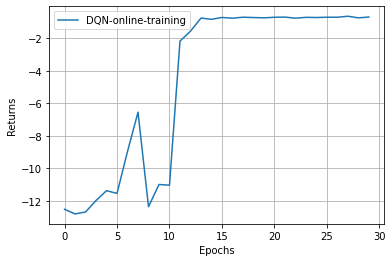

In [39]:
import pandas as pd
dt_statistics = pd.read_csv('d3rlpy_logs/DQN_online_20240413145812/rollout_return.csv', header=None)

plt.plot(dt_statistics[2], label="DQN-online-training")
plt.xlabel("Epochs")
plt.ylabel("Returns")
plt.legend()
plt.grid()

Вроде бы неплохо обучился, но пока не совсем идеально - при отсутсвии лишних шагов можно набрать 0 или чуть выше. Но думаю эти данные уже можно использовать в offline-обучении в качестве эталонных.

# Offline Behavior Cloning (BC)

Behavior Cloning (BC) is to imitate actions in the dataset via a supervised learning approach. Since BC is only imitating action distributions, the performance will be close to the mean of the dataset even though BC mostly works better than online RL algorithms.

Здесь я немного меняю параметры - делаю меньше learning rate и gamma, так как при дефолтных значениях алгоритм не учился. Запускаем обучение.

In [10]:
bc = d3rlpy.algos.DiscreteBCConfig(learning_rate=0.0001, gamma=0.9).create(device='cuda:0')

# start training
statistics_bc = bc.fit(
    dqn_buffer,
    n_steps=100000,
    n_steps_per_epoch=5000,
    evaluators={
        'environment': d3rlpy.metrics.EnvironmentEvaluator(env),
    },
)

2024-04-13 15:13.38 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(49,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[()]), reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2024-04-13 15:13.38 [info     ] Directory is created at d3rlpy_logs/DiscreteBC_20240413151338
2024-04-13 15:13.38 [debug    ] Building models...            
2024-04-13 15:13.38 [debug    ] Models have been built.       
2024-04-13 15:13.38 [info     ] Parameters                     params={'observation_shape': [49], 'action_size': 5, 'config': {'type': 'discrete_bc', 'params': {'batch_size': 100, 'gamma': 0.9, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 0.0001, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0

Epoch 1/20: 100%|██████████| 5000/5000 [00:26<00:00, 187.35it/s, loss=2.78]


2024-04-13 15:14.05 [info     ] DiscreteBC_20240413151338: epoch=1 step=5000 epoch=1 metrics={'time_sample_batch': 0.0036174072265625, 'time_algorithm_update': 0.0016079576492309571, 'loss': 2.776480276489258, 'time_step': 0.005307954120635987, 'environment': 0.10000000000000009} step=5000
2024-04-13 15:14.05 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240413151338/model_5000.d3


Epoch 2/20: 100%|██████████| 5000/5000 [00:26<00:00, 188.06it/s, loss=2.77]


2024-04-13 15:14.32 [info     ] DiscreteBC_20240413151338: epoch=2 step=10000 epoch=2 metrics={'time_sample_batch': 0.003613191604614258, 'time_algorithm_update': 0.0015913578033447265, 'loss': 2.7741408906936647, 'time_step': 0.005288004493713379, 'environment': 0.10000000000000009} step=10000
2024-04-13 15:14.32 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240413151338/model_10000.d3


Epoch 3/20: 100%|██████████| 5000/5000 [00:27<00:00, 185.05it/s, loss=2.77]


2024-04-13 15:14.59 [info     ] DiscreteBC_20240413151338: epoch=3 step=15000 epoch=3 metrics={'time_sample_batch': 0.0036233589172363283, 'time_algorithm_update': 0.0016632376194000245, 'loss': 2.7748623334407805, 'time_step': 0.005371978235244751, 'environment': 0.10000000000000009} step=15000
2024-04-13 15:14.59 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240413151338/model_15000.d3


Epoch 4/20: 100%|██████████| 5000/5000 [00:26<00:00, 185.68it/s, loss=2.77]


2024-04-13 15:15.26 [info     ] DiscreteBC_20240413151338: epoch=4 step=20000 epoch=4 metrics={'time_sample_batch': 0.0036119083881378175, 'time_algorithm_update': 0.0016606989860534667, 'loss': 2.7739523351192474, 'time_step': 0.0053557278156280514, 'environment': 0.10000000000000009} step=20000
2024-04-13 15:15.26 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240413151338/model_20000.d3


Epoch 5/20: 100%|██████████| 5000/5000 [00:26<00:00, 186.87it/s, loss=2.77]


2024-04-13 15:15.53 [info     ] DiscreteBC_20240413151338: epoch=5 step=25000 epoch=5 metrics={'time_sample_batch': 0.0036017123222351075, 'time_algorithm_update': 0.001636998987197876, 'loss': 2.7737502334117887, 'time_step': 0.005322188377380371, 'environment': 0.10000000000000009} step=25000
2024-04-13 15:15.53 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240413151338/model_25000.d3


Epoch 6/20: 100%|██████████| 5000/5000 [00:26<00:00, 190.27it/s, loss=2.77]


2024-04-13 15:16.19 [info     ] DiscreteBC_20240413151338: epoch=6 step=30000 epoch=6 metrics={'time_sample_batch': 0.0035838228702545164, 'time_algorithm_update': 0.0015624590396881104, 'loss': 2.77374481754303, 'time_step': 0.005226687335968018, 'environment': 0.10000000000000009} step=30000
2024-04-13 15:16.19 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240413151338/model_30000.d3


Epoch 7/20: 100%|██████████| 5000/5000 [00:26<00:00, 190.16it/s, loss=2.77]


2024-04-13 15:16.46 [info     ] DiscreteBC_20240413151338: epoch=7 step=35000 epoch=7 metrics={'time_sample_batch': 0.0035769807815551756, 'time_algorithm_update': 0.001570662260055542, 'loss': 2.774405163192749, 'time_step': 0.005230057430267334, 'environment': 0.10000000000000009} step=35000
2024-04-13 15:16.46 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240413151338/model_35000.d3


Epoch 8/20: 100%|██████████| 5000/5000 [00:26<00:00, 189.02it/s, loss=2.77]


2024-04-13 15:17.12 [info     ] DiscreteBC_20240413151338: epoch=8 step=40000 epoch=8 metrics={'time_sample_batch': 0.0035956388473510742, 'time_algorithm_update': 0.0015834116458892822, 'loss': 2.773943639945984, 'time_step': 0.005261702489852906, 'environment': 0.10000000000000009} step=40000
2024-04-13 15:17.12 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240413151338/model_40000.d3


Epoch 9/20: 100%|██████████| 5000/5000 [00:26<00:00, 188.75it/s, loss=2.77]


2024-04-13 15:17.39 [info     ] DiscreteBC_20240413151338: epoch=9 step=45000 epoch=9 metrics={'time_sample_batch': 0.003598611402511597, 'time_algorithm_update': 0.0015874906539916991, 'loss': 2.7741387177944183, 'time_step': 0.005268459796905518, 'environment': 0.10000000000000009} step=45000
2024-04-13 15:17.39 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240413151338/model_45000.d3


Epoch 10/20: 100%|██████████| 5000/5000 [00:26<00:00, 189.26it/s, loss=2.77]


2024-04-13 15:18.05 [info     ] DiscreteBC_20240413151338: epoch=10 step=50000 epoch=10 metrics={'time_sample_batch': 0.0035865203857421875, 'time_algorithm_update': 0.0015862576961517335, 'loss': 2.773502482461929, 'time_step': 0.0052555496215820315, 'environment': 0.10000000000000009} step=50000
2024-04-13 15:18.05 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240413151338/model_50000.d3


Epoch 11/20: 100%|██████████| 5000/5000 [00:26<00:00, 190.59it/s, loss=2.77]


2024-04-13 15:18.32 [info     ] DiscreteBC_20240413151338: epoch=11 step=55000 epoch=11 metrics={'time_sample_batch': 0.0035581128597259523, 'time_algorithm_update': 0.001575281858444214, 'loss': 2.774106460762024, 'time_step': 0.005218890857696533, 'environment': 0.10000000000000009} step=55000
2024-04-13 15:18.32 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240413151338/model_55000.d3


Epoch 12/20: 100%|██████████| 5000/5000 [00:26<00:00, 187.67it/s, loss=2.77]


2024-04-13 15:18.58 [info     ] DiscreteBC_20240413151338: epoch=12 step=60000 epoch=12 metrics={'time_sample_batch': 0.0036090086936950683, 'time_algorithm_update': 0.0015937036991119384, 'loss': 2.77404920129776, 'time_step': 0.005297838830947876, 'environment': 0.10000000000000009} step=60000
2024-04-13 15:18.58 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240413151338/model_60000.d3


Epoch 13/20: 100%|██████████| 5000/5000 [00:27<00:00, 184.21it/s, loss=2.77]


2024-04-13 15:19.26 [info     ] DiscreteBC_20240413151338: epoch=13 step=65000 epoch=13 metrics={'time_sample_batch': 0.0036467824935913088, 'time_algorithm_update': 0.0016499691486358643, 'loss': 2.7742896309375764, 'time_step': 0.005396117210388183, 'environment': 0.10000000000000009} step=65000
2024-04-13 15:19.26 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240413151338/model_65000.d3


Epoch 14/20: 100%|██████████| 5000/5000 [00:27<00:00, 185.18it/s, loss=2.77]


2024-04-13 15:19.53 [info     ] DiscreteBC_20240413151338: epoch=14 step=70000 epoch=14 metrics={'time_sample_batch': 0.0036381691932678224, 'time_algorithm_update': 0.0016297021865844727, 'loss': 2.7742342073917388, 'time_step': 0.005366966581344604, 'environment': 0.10000000000000009} step=70000
2024-04-13 15:19.53 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240413151338/model_70000.d3


Epoch 15/20: 100%|██████████| 5000/5000 [00:26<00:00, 185.80it/s, loss=2.77]


2024-04-13 15:20.20 [info     ] DiscreteBC_20240413151338: epoch=15 step=75000 epoch=15 metrics={'time_sample_batch': 0.003638271379470825, 'time_algorithm_update': 0.0016149096012115479, 'loss': 2.772952657699585, 'time_step': 0.005350379419326782, 'environment': 0.10000000000000009} step=75000
2024-04-13 15:20.20 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240413151338/model_75000.d3


Epoch 16/20: 100%|██████████| 5000/5000 [00:26<00:00, 185.35it/s, loss=2.77]


2024-04-13 15:20.47 [info     ] DiscreteBC_20240413151338: epoch=16 step=80000 epoch=16 metrics={'time_sample_batch': 0.0036558003902435305, 'time_algorithm_update': 0.001611439037322998, 'loss': 2.7734867696285246, 'time_step': 0.005364054536819458, 'environment': 0.10000000000000009} step=80000
2024-04-13 15:20.47 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240413151338/model_80000.d3


Epoch 17/20: 100%|██████████| 5000/5000 [00:27<00:00, 181.26it/s, loss=2.77]


2024-04-13 15:21.15 [info     ] DiscreteBC_20240413151338: epoch=17 step=85000 epoch=17 metrics={'time_sample_batch': 0.0037493647575378417, 'time_algorithm_update': 0.0016306805610656738, 'loss': 2.774012933444977, 'time_step': 0.005481673097610474, 'environment': 0.10000000000000009} step=85000
2024-04-13 15:21.15 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240413151338/model_85000.d3


Epoch 18/20: 100%|██████████| 5000/5000 [00:28<00:00, 176.66it/s, loss=2.77]


2024-04-13 15:21.43 [info     ] DiscreteBC_20240413151338: epoch=18 step=90000 epoch=18 metrics={'time_sample_batch': 0.0038741576194763184, 'time_algorithm_update': 0.0016424619197845458, 'loss': 2.773426079559326, 'time_step': 0.0056227565288543705, 'environment': 0.10000000000000009} step=90000
2024-04-13 15:21.43 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240413151338/model_90000.d3


Epoch 19/20: 100%|██████████| 5000/5000 [00:27<00:00, 183.54it/s, loss=2.77]


2024-04-13 15:22.10 [info     ] DiscreteBC_20240413151338: epoch=19 step=95000 epoch=19 metrics={'time_sample_batch': 0.0036643407821655275, 'time_algorithm_update': 0.001653248929977417, 'loss': 2.773181606864929, 'time_step': 0.005416619634628296, 'environment': 0.10000000000000009} step=95000
2024-04-13 15:22.10 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240413151338/model_95000.d3


Epoch 20/20: 100%|██████████| 5000/5000 [00:27<00:00, 182.37it/s, loss=2.77]


2024-04-13 15:22.38 [info     ] DiscreteBC_20240413151338: epoch=20 step=100000 epoch=20 metrics={'time_sample_batch': 0.0036931878089904785, 'time_algorithm_update': 0.0016570877075195313, 'loss': 2.774014704656601, 'time_step': 0.0054500922203063965, 'environment': 0.10000000000000009} step=100000
2024-04-13 15:22.38 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240413151338/model_100000.d3


В принципе такое кол-во шагов было излишним, алгоритм научился быстро проходить лабиринт уже в превой эпохе :)

# Conservative Q-Learning algorithm (CQL).

CQL is a SAC-based data-driven deep reinforcement learning algorithm, which achieves state-of-the-art performance in offline RL problems.

CQL mitigates overestimation error by minimizing action-values under the current policy and maximizing values under data distribution for underestimation issue.

Оставляю все параметры дефолтными.

In [11]:
# setup CQL algorithm
cql = d3rlpy.algos.DiscreteCQLConfig().create(device='cuda:0')

# start training
statistics_cql = cql.fit(
    dqn_buffer,
    n_steps=100000,
    n_steps_per_epoch=5000,
    evaluators={
        'environment': d3rlpy.metrics.EnvironmentEvaluator(env),
    },
)

2024-04-13 15:22.46 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(49,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[()]), reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2024-04-13 15:22.46 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20240413152246
2024-04-13 15:22.46 [debug    ] Building models...            
2024-04-13 15:22.46 [debug    ] Models have been built.       
2024-04-13 15:22.46 [info     ] Parameters                     params={'observation_shape': [49], 'action_size': 5, 'config': {'type': 'discrete_cql', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 6.25e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.

Epoch 1/20: 100%|██████████| 5000/5000 [00:22<00:00, 225.05it/s, loss=1.41, td_loss=0.0909, conservative_loss=1.32]


2024-04-13 15:23.09 [info     ] DiscreteCQL_20240413152246: epoch=1 step=5000 epoch=1 metrics={'time_sample_batch': 0.001287923002243042, 'time_algorithm_update': 0.0029849580764770506, 'loss': 1.4067183235168457, 'td_loss': 0.09092485747016035, 'conservative_loss': 1.3157934662103652, 'time_step': 0.004410223722457886, 'environment': 0.10000000000000009} step=5000
2024-04-13 15:23.09 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240413152246/model_5000.d3


Epoch 2/20: 100%|██████████| 5000/5000 [00:22<00:00, 221.94it/s, loss=1.39, td_loss=0.0986, conservative_loss=1.3]


2024-04-13 15:23.31 [info     ] DiscreteCQL_20240413152246: epoch=2 step=10000 epoch=2 metrics={'time_sample_batch': 0.0012639410495758057, 'time_algorithm_update': 0.003051754903793335, 'loss': 1.394083631515503, 'td_loss': 0.09859686334431171, 'conservative_loss': 1.2954867698669434, 'time_step': 0.004470475482940674, 'environment': 0.10000000000000009} step=10000
2024-04-13 15:23.31 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240413152246/model_10000.d3


Epoch 3/20: 100%|██████████| 5000/5000 [00:22<00:00, 218.49it/s, loss=1.39, td_loss=0.0959, conservative_loss=1.29]


2024-04-13 15:23.54 [info     ] DiscreteCQL_20240413152246: epoch=3 step=15000 epoch=3 metrics={'time_sample_batch': 0.0012780495166778564, 'time_algorithm_update': 0.0031110344409942627, 'loss': 1.3882554588794709, 'td_loss': 0.09586297463700175, 'conservative_loss': 1.2923924844503403, 'time_step': 0.004542998886108399, 'environment': 0.10000000000000009} step=15000
2024-04-13 15:23.54 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240413152246/model_15000.d3


Epoch 4/20: 100%|██████████| 5000/5000 [00:23<00:00, 211.84it/s, loss=1.39, td_loss=0.0958, conservative_loss=1.29]


2024-04-13 15:24.18 [info     ] DiscreteCQL_20240413152246: epoch=4 step=20000 epoch=4 metrics={'time_sample_batch': 0.001373718023300171, 'time_algorithm_update': 0.003168099880218506, 'loss': 1.3890800566911696, 'td_loss': 0.0958212928622961, 'conservative_loss': 1.2932587631106376, 'time_step': 0.004688185930252075, 'environment': 0.10000000000000009} step=20000
2024-04-13 15:24.18 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240413152246/model_20000.d3


Epoch 5/20: 100%|██████████| 5000/5000 [00:23<00:00, 212.81it/s, loss=1.39, td_loss=0.0957, conservative_loss=1.29]


2024-04-13 15:24.42 [info     ] DiscreteCQL_20240413152246: epoch=5 step=25000 epoch=5 metrics={'time_sample_batch': 0.0013594173431396483, 'time_algorithm_update': 0.003161212682723999, 'loss': 1.3873169519662858, 'td_loss': 0.09571438642293215, 'conservative_loss': 1.291602565598488, 'time_step': 0.004666975498199463, 'environment': 0.10000000000000009} step=25000
2024-04-13 15:24.42 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240413152246/model_25000.d3


Epoch 6/20: 100%|██████████| 5000/5000 [00:23<00:00, 212.66it/s, loss=1.38, td_loss=0.0947, conservative_loss=1.29]


2024-04-13 15:25.05 [info     ] DiscreteCQL_20240413152246: epoch=6 step=30000 epoch=6 metrics={'time_sample_batch': 0.0013519374370574951, 'time_algorithm_update': 0.0031737337589263915, 'loss': 1.3840624923229217, 'td_loss': 0.09465710356906057, 'conservative_loss': 1.2894053888082504, 'time_step': 0.004670980787277222, 'environment': 0.10000000000000009} step=30000
2024-04-13 15:25.05 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240413152246/model_30000.d3


Epoch 7/20: 100%|██████████| 5000/5000 [00:23<00:00, 215.35it/s, loss=1.39, td_loss=0.0976, conservative_loss=1.29]


2024-04-13 15:25.29 [info     ] DiscreteCQL_20240413152246: epoch=7 step=35000 epoch=7 metrics={'time_sample_batch': 0.001291635274887085, 'time_algorithm_update': 0.003156767416000366, 'loss': 1.387289030122757, 'td_loss': 0.09759000415578485, 'conservative_loss': 1.2896990262031556, 'time_step': 0.0046067018985748295, 'environment': 0.10000000000000009} step=35000
2024-04-13 15:25.29 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240413152246/model_35000.d3


Epoch 8/20: 100%|██████████| 5000/5000 [00:22<00:00, 221.42it/s, loss=1.39, td_loss=0.0962, conservative_loss=1.3] 


2024-04-13 15:25.51 [info     ] DiscreteCQL_20240413152246: epoch=8 step=40000 epoch=8 metrics={'time_sample_batch': 0.0012673779010772706, 'time_algorithm_update': 0.0030548875808715822, 'loss': 1.3930989750862122, 'td_loss': 0.09622899962961674, 'conservative_loss': 1.2968699755430222, 'time_step': 0.0044807093620300295, 'environment': 0.10000000000000009} step=40000
2024-04-13 15:25.51 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240413152246/model_40000.d3


Epoch 9/20: 100%|██████████| 5000/5000 [00:22<00:00, 226.40it/s, loss=1.4, td_loss=0.101, conservative_loss=1.3] 


2024-04-13 15:26.13 [info     ] DiscreteCQL_20240413152246: epoch=9 step=45000 epoch=9 metrics={'time_sample_batch': 0.0012602018356323243, 'time_algorithm_update': 0.002964711046218872, 'loss': 1.4003781465768814, 'td_loss': 0.10133254338130356, 'conservative_loss': 1.299045603132248, 'time_step': 0.004381442022323608, 'environment': 0.10000000000000009} step=45000
2024-04-13 15:26.13 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240413152246/model_45000.d3


Epoch 10/20: 100%|██████████| 5000/5000 [00:22<00:00, 222.65it/s, loss=1.4, td_loss=0.104, conservative_loss=1.3]  


2024-04-13 15:26.36 [info     ] DiscreteCQL_20240413152246: epoch=10 step=50000 epoch=10 metrics={'time_sample_batch': 0.001274587917327881, 'time_algorithm_update': 0.003020017147064209, 'loss': 1.4001038152217864, 'td_loss': 0.10415992689952254, 'conservative_loss': 1.2959438879728318, 'time_step': 0.0044563560962677, 'environment': 0.10000000000000009} step=50000
2024-04-13 15:26.36 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240413152246/model_50000.d3


Epoch 11/20: 100%|██████████| 5000/5000 [00:22<00:00, 224.32it/s, loss=1.41, td_loss=0.105, conservative_loss=1.3]


2024-04-13 15:26.58 [info     ] DiscreteCQL_20240413152246: epoch=11 step=55000 epoch=11 metrics={'time_sample_batch': 0.0012712773323059082, 'time_algorithm_update': 0.0029902931690216064, 'loss': 1.4058091377258302, 'td_loss': 0.10532537981048226, 'conservative_loss': 1.3004837581157684, 'time_step': 0.004422548723220825, 'environment': 0.10000000000000009} step=55000
2024-04-13 15:26.58 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240413152246/model_55000.d3


Epoch 12/20: 100%|██████████| 5000/5000 [00:22<00:00, 225.22it/s, loss=1.42, td_loss=0.108, conservative_loss=1.31]


2024-04-13 15:27.21 [info     ] DiscreteCQL_20240413152246: epoch=12 step=60000 epoch=12 metrics={'time_sample_batch': 0.0012696247577667237, 'time_algorithm_update': 0.002972373867034912, 'loss': 1.4153408010482789, 'td_loss': 0.10810199595987796, 'conservative_loss': 1.307238804626465, 'time_step': 0.004404209470748902, 'environment': 0.10000000000000009} step=60000
2024-04-13 15:27.21 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240413152246/model_60000.d3


Epoch 13/20: 100%|██████████| 5000/5000 [00:22<00:00, 224.99it/s, loss=1.41, td_loss=0.111, conservative_loss=1.3]


2024-04-13 15:27.43 [info     ] DiscreteCQL_20240413152246: epoch=13 step=65000 epoch=13 metrics={'time_sample_batch': 0.001268405818939209, 'time_algorithm_update': 0.0029840705871582033, 'loss': 1.414416684436798, 'td_loss': 0.11100534735321999, 'conservative_loss': 1.303411337518692, 'time_step': 0.0044105058193206785, 'environment': 0.10000000000000009} step=65000
2024-04-13 15:27.43 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240413152246/model_65000.d3


Epoch 14/20: 100%|██████████| 5000/5000 [00:22<00:00, 223.93it/s, loss=1.42, td_loss=0.112, conservative_loss=1.31]


2024-04-13 15:28.05 [info     ] DiscreteCQL_20240413152246: epoch=14 step=70000 epoch=14 metrics={'time_sample_batch': 0.001279210090637207, 'time_algorithm_update': 0.0029975711822509766, 'loss': 1.4175092106103897, 'td_loss': 0.11200760401561856, 'conservative_loss': 1.3055016061067581, 'time_step': 0.004432041645050049, 'environment': 0.10000000000000009} step=70000
2024-04-13 15:28.05 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240413152246/model_70000.d3


Epoch 15/20: 100%|██████████| 5000/5000 [00:22<00:00, 226.23it/s, loss=1.43, td_loss=0.115, conservative_loss=1.31]


2024-04-13 15:28.28 [info     ] DiscreteCQL_20240413152246: epoch=15 step=75000 epoch=15 metrics={'time_sample_batch': 0.0012628987789154052, 'time_algorithm_update': 0.002978848361968994, 'loss': 1.425272755074501, 'td_loss': 0.11495583857446909, 'conservative_loss': 1.3103169167160988, 'time_step': 0.0043874860286712645, 'environment': 0.10000000000000009} step=75000
2024-04-13 15:28.28 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240413152246/model_75000.d3


Epoch 16/20: 100%|██████████| 5000/5000 [00:21<00:00, 229.08it/s, loss=1.43, td_loss=0.116, conservative_loss=1.31]


2024-04-13 15:28.50 [info     ] DiscreteCQL_20240413152246: epoch=16 step=80000 epoch=16 metrics={'time_sample_batch': 0.0012453737258911132, 'time_algorithm_update': 0.002980674934387207, 'loss': 1.4284454363107681, 'td_loss': 0.11640751856938004, 'conservative_loss': 1.3120379173278809, 'time_step': 0.004341867733001709, 'environment': 0.10000000000000009} step=80000
2024-04-13 15:28.50 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240413152246/model_80000.d3


Epoch 17/20: 100%|██████████| 5000/5000 [00:22<00:00, 222.33it/s, loss=1.44, td_loss=0.122, conservative_loss=1.31]


2024-04-13 15:29.12 [info     ] DiscreteCQL_20240413152246: epoch=17 step=85000 epoch=17 metrics={'time_sample_batch': 0.0012844813346862792, 'time_algorithm_update': 0.003043273305892944, 'loss': 1.4355736270189285, 'td_loss': 0.12236901696100831, 'conservative_loss': 1.313204609632492, 'time_step': 0.004466038465499878, 'environment': 0.10000000000000009} step=85000
2024-04-13 15:29.12 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240413152246/model_85000.d3


Epoch 18/20: 100%|██████████| 5000/5000 [00:23<00:00, 216.52it/s, loss=1.44, td_loss=0.124, conservative_loss=1.32]


2024-04-13 15:29.35 [info     ] DiscreteCQL_20240413152246: epoch=18 step=90000 epoch=18 metrics={'time_sample_batch': 0.001271128225326538, 'time_algorithm_update': 0.003170299196243286, 'loss': 1.4387818069458007, 'td_loss': 0.12358686801791191, 'conservative_loss': 1.3151949385643005, 'time_step': 0.00458255090713501, 'environment': 0.10000000000000009} step=90000
2024-04-13 15:29.35 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240413152246/model_90000.d3


Epoch 19/20: 100%|██████████| 5000/5000 [00:23<00:00, 217.03it/s, loss=1.44, td_loss=0.125, conservative_loss=1.32]


2024-04-13 15:29.58 [info     ] DiscreteCQL_20240413152246: epoch=19 step=95000 epoch=19 metrics={'time_sample_batch': 0.0012642446041107177, 'time_algorithm_update': 0.003168066310882568, 'loss': 1.4442410432100297, 'td_loss': 0.1249830648638308, 'conservative_loss': 1.3192579786539078, 'time_step': 0.004572111463546753, 'environment': 0.10000000000000009} step=95000
2024-04-13 15:29.58 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240413152246/model_95000.d3


Epoch 20/20: 100%|██████████| 5000/5000 [00:22<00:00, 217.77it/s, loss=1.45, td_loss=0.132, conservative_loss=1.32]


2024-04-13 15:30.22 [info     ] DiscreteCQL_20240413152246: epoch=20 step=100000 epoch=20 metrics={'time_sample_batch': 0.0012566610813140868, 'time_algorithm_update': 0.0031591282844543457, 'loss': 1.4514029879570007, 'td_loss': 0.1323871470823884, 'conservative_loss': 1.3190158407688142, 'time_step': 0.004556981086730957, 'environment': 0.10000000000000009} step=100000
2024-04-13 15:30.22 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240413152246/model_100000.d3


Также быстро обучился агент в этом алгоритме после 5000 шагов. Как-то подозрительно показалось, поэтому решила проверить и отрисовать прохождение. Видео не получилось сделать, отрисовала кадры ниже.

In [12]:
test_episodes = 1
total_rewards = 0

for _ in range(test_episodes):
  observation = env.reset()
  observation = observation[0].reshape(1, -1)
  episode_reward = 0
  while True:
    action = cql.predict(observation)[0]
    new_observation, reward, truncated, terminated, _ = env.step(action)
    done = truncated | terminated
    episode_reward += reward
    observation = new_observation.reshape(1, -1)
    env.render()
    if done:
        break
  
  total_rewards += episode_reward

print("Total rewards: " + str(total_rewards))

 .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  . 
 .  .                                                     .  . 
 .  .     .  .     .        .  .  .     .  .  .     .     .  . 
 .  .              .  .  .  .        .     .     .  .     .  . 
 .  .     .              .  .  .     .           .        .  . 
 .  .     .  .  .  .  .     .        .     .     .  .     .  . 
 .  .     .  .     .  .     .  .  .     .        .        .  . 
 .  .     .     .     .  .  .        .  .  .     .  .     .  . 
 .  .        . |0| .  .  .  .  .  .  .  .  .     .        .  . 
 .  .        .  .  .     .  .  .              .           .  . 
 .  .     .  .     .  .        .     .           .        .  . 
 .  .     .     .  .  .  .  .        .  .  .     .        .  . 
 .  .        .     .     .  .  .           .  .  .  .     .  . 
 .  .                 .  .  .  .        .  .     .        .  . 
 .  .           .  0  .        .        

Действительно, агент упорно идет к цели без лишних блужданий.

# DiscreteDecisionTransformer (DT)
Decision Transformer solves decision-making problems as a sequence modeling problem.

Использую дефолтные параметры, добавляю только SoftmaxTransformerActionSampler для оценки алгоритма в процессе обучения. Нужно именно с softmax, так как action из DT выводится в виде вектора вероятностей длиной равной количеству действий. Чтобы вывести число действия и нужен softmax.

In [14]:
dt = d3rlpy.algos.DiscreteDecisionTransformerConfig().create(device="cuda:0")

# offline training
statistics_dt = dt.fit(
   dqn_buffer,
   n_steps=100000,
   n_steps_per_epoch=5000,
   eval_env=env,
   eval_target_return=0,
   # manually specify action-sampler
   eval_action_sampler=d3rlpy.algos.SoftmaxTransformerActionSampler(),
)

2024-04-13 15:31.51 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(49,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[()]), reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2024-04-13 15:31.51 [info     ] Directory is created at d3rlpy_logs/DiscreteDecisionTransformer_20240413153151
2024-04-13 15:31.51 [debug    ] Building models...            
2024-04-13 15:31.51 [debug    ] Models have been built.       
2024-04-13 15:31.51 [info     ] Parameters                     params={'observation_shape': [49], 'action_size': 5, 'config': {'type': 'discrete_decision_transformer', 'params': {'batch_size': 128, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'context_size': 20, 'max_timestep': 1000, 'learnin

Epoch 1/20: 100%|██████████| 5000/5000 [03:39<00:00, 22.79it/s, loss=0.709, learning_rate=0.000568]


2024-04-13 15:35.34 [info     ] DiscreteDecisionTransformer_20240413153151: epoch=1 step=5000 epoch=1 metrics={'time_sample_batch': 0.007373399305343628, 'time_algorithm_update': 0.03605094819068909, 'loss': 0.7092557162165641, 'learning_rate': 0.0005680388415829969, 'time_step': 0.04359297285079956, 'environment': -0.3499999999999999} step=5000
2024-04-13 15:35.35 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteDecisionTransformer_20240413153151/model_5000.d3


Epoch 2/20: 100%|██████████| 5000/5000 [03:38<00:00, 22.91it/s, loss=0.674, learning_rate=0.000402]


2024-04-13 15:39.18 [info     ] DiscreteDecisionTransformer_20240413153151: epoch=2 step=10000 epoch=2 metrics={'time_sample_batch': 0.007297223615646362, 'time_algorithm_update': 0.035892877149581906, 'loss': 0.6737064440131187, 'learning_rate': 0.00040221216723885806, 'time_step': 0.043361050891876224, 'environment': -0.7999999999999998} step=10000
2024-04-13 15:39.18 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteDecisionTransformer_20240413153151/model_10000.d3


Epoch 3/20: 100%|██████████| 5000/5000 [03:37<00:00, 22.94it/s, loss=0.622, learning_rate=0.000173]


2024-04-13 15:43.02 [info     ] DiscreteDecisionTransformer_20240413153151: epoch=3 step=15000 epoch=3 metrics={'time_sample_batch': 0.007256852388381958, 'time_algorithm_update': 0.03587194418907166, 'loss': 0.6218542356967927, 'learning_rate': 0.00017268523052651544, 'time_step': 0.04329980845451355, 'environment': -1.0999999999999999} step=15000
2024-04-13 15:43.03 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteDecisionTransformer_20240413153151/model_15000.d3


Epoch 4/20: 100%|██████████| 5000/5000 [03:38<00:00, 22.92it/s, loss=0.576, learning_rate=6.06e-5]


2024-04-13 15:46.47 [info     ] DiscreteDecisionTransformer_20240413153151: epoch=4 step=20000 epoch=4 metrics={'time_sample_batch': 0.007274429512023926, 'time_algorithm_update': 0.03591199374198913, 'loss': 0.576331861191988, 'learning_rate': 6.058314092320431e-05, 'time_step': 0.043356725120544434, 'environment': -1.02} step=20000
2024-04-13 15:46.47 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteDecisionTransformer_20240413153151/model_20000.d3


Epoch 5/20: 100%|██████████| 5000/5000 [03:38<00:00, 22.87it/s, loss=0.548, learning_rate=6.83e-5]


2024-04-13 15:50.31 [info     ] DiscreteDecisionTransformer_20240413153151: epoch=5 step=25000 epoch=5 metrics={'time_sample_batch': 0.007324379110336304, 'time_algorithm_update': 0.03596124758720398, 'loss': 0.5480073208153248, 'learning_rate': 6.8345051753882e-05, 'time_step': 0.04345263514518738, 'environment': -0.9999999999999998} step=25000
2024-04-13 15:50.32 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteDecisionTransformer_20240413153151/model_25000.d3


Epoch 6/20: 100%|██████████| 5000/5000 [03:40<00:00, 22.72it/s, loss=0.517, learning_rate=0.000224]


2024-04-13 15:54.17 [info     ] DiscreteDecisionTransformer_20240413153151: epoch=6 step=30000 epoch=6 metrics={'time_sample_batch': 0.007386889219284058, 'time_algorithm_update': 0.03618271508216858, 'loss': 0.5165827031672001, 'learning_rate': 0.00022405571555521417, 'time_step': 0.04373455257415772, 'environment': -0.8999999999999998} step=30000
2024-04-13 15:54.17 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteDecisionTransformer_20240413153151/model_30000.d3


Epoch 7/20: 100%|██████████| 5000/5000 [03:39<00:00, 22.76it/s, loss=0.454, learning_rate=0.000451]


2024-04-13 15:58.03 [info     ] DiscreteDecisionTransformer_20240413153151: epoch=7 step=35000 epoch=7 metrics={'time_sample_batch': 0.0073406594276428224, 'time_algorithm_update': 0.03614228739738464, 'loss': 0.4542841104865074, 'learning_rate': 0.0004515155939081974, 'time_step': 0.04365042233467102, 'environment': -1.14} step=35000
2024-04-13 15:58.03 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteDecisionTransformer_20240413153151/model_35000.d3


Epoch 8/20: 100%|██████████| 5000/5000 [03:38<00:00, 22.90it/s, loss=0.39, learning_rate=0.000585] 


2024-04-13 16:01.46 [info     ] DiscreteDecisionTransformer_20240413153151: epoch=8 step=40000 epoch=8 metrics={'time_sample_batch': 0.007329999399185181, 'time_algorithm_update': 0.03590375394821167, 'loss': 0.389933638215065, 'learning_rate': 0.0005851072459109027, 'time_step': 0.043398249626159666, 'environment': -0.7099999999999999} step=40000
2024-04-13 16:01.47 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteDecisionTransformer_20240413153151/model_40000.d3


Epoch 9/20: 100%|██████████| 5000/5000 [03:38<00:00, 22.91it/s, loss=0.34, learning_rate=0.000542] 


2024-04-13 16:05.30 [info     ] DiscreteDecisionTransformer_20240413153151: epoch=9 step=45000 epoch=9 metrics={'time_sample_batch': 0.007332313060760498, 'time_algorithm_update': 0.03587887167930603, 'loss': 0.3395114963769913, 'learning_rate': 0.000542006023953896, 'time_step': 0.04337455005645752, 'environment': -0.8299999999999998} step=45000
2024-04-13 16:05.31 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteDecisionTransformer_20240413153151/model_45000.d3


Epoch 10/20: 100%|██████████| 5000/5000 [03:38<00:00, 22.89it/s, loss=0.298, learning_rate=0.000349]


2024-04-13 16:09.14 [info     ] DiscreteDecisionTransformer_20240413153151: epoch=10 step=50000 epoch=10 metrics={'time_sample_batch': 0.007309520006179809, 'time_algorithm_update': 0.03594467101097107, 'loss': 0.2984038496851921, 'learning_rate': 0.0003491838729952355, 'time_step': 0.04341415386199951, 'environment': -0.7299999999999998} step=50000
2024-04-13 16:09.14 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteDecisionTransformer_20240413153151/model_50000.d3


Epoch 11/20: 100%|██████████| 5000/5000 [03:38<00:00, 22.92it/s, loss=0.269, learning_rate=0.000127]


2024-04-13 16:12.58 [info     ] DiscreteDecisionTransformer_20240413153151: epoch=11 step=55000 epoch=11 metrics={'time_sample_batch': 0.007351127052307129, 'time_algorithm_update': 0.03585959053039551, 'loss': 0.2692433037519455, 'learning_rate': 0.0001272960174707134, 'time_step': 0.04336924815177917, 'environment': -0.5099999999999999} step=55000
2024-04-13 16:12.58 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteDecisionTransformer_20240413153151/model_55000.d3


Epoch 12/20: 100%|██████████| 5000/5000 [03:38<00:00, 22.93it/s, loss=0.259, learning_rate=6e-5]


2024-04-13 16:16.41 [info     ] DiscreteDecisionTransformer_20240413153151: epoch=12 step=60000 epoch=12 metrics={'time_sample_batch': 0.0073252102375030515, 'time_algorithm_update': 0.035852268123626706, 'loss': 0.2591750016272068, 'learning_rate': 6.000000000000334e-05, 'time_step': 0.043335738134384155, 'environment': -0.5499999999999999} step=60000
2024-04-13 16:16.42 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteDecisionTransformer_20240413153151/model_60000.d3


Epoch 13/20: 100%|██████████| 5000/5000 [03:37<00:00, 22.94it/s, loss=0.258, learning_rate=8.6e-5] 


2024-04-13 16:20.24 [info     ] DiscreteDecisionTransformer_20240413153151: epoch=13 step=65000 epoch=13 metrics={'time_sample_batch': 0.007322647380828857, 'time_algorithm_update': 0.03585564022064209, 'loss': 0.2581567503660917, 'learning_rate': 8.610096491204865e-05, 'time_step': 0.043333423566818234, 'environment': -0.3999999999999998} step=65000
2024-04-13 16:20.24 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteDecisionTransformer_20240413153151/model_65000.d3


Epoch 14/20: 100%|██████████| 5000/5000 [03:38<00:00, 22.92it/s, loss=0.271, learning_rate=0.000277]


2024-04-13 16:24.07 [info     ] DiscreteDecisionTransformer_20240413153151: epoch=14 step=70000 epoch=14 metrics={'time_sample_batch': 0.00735313549041748, 'time_algorithm_update': 0.03585658974647522, 'loss': 0.27124518518149854, 'learning_rate': 0.0002774630457679244, 'time_step': 0.043367999744415284, 'environment': -0.7199999999999999} step=70000
2024-04-13 16:24.08 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteDecisionTransformer_20240413153151/model_70000.d3


Epoch 15/20: 100%|██████████| 5000/5000 [03:38<00:00, 22.92it/s, loss=0.285, learning_rate=0.000495]


2024-04-13 16:27.51 [info     ] DiscreteDecisionTransformer_20240413153151: epoch=15 step=75000 epoch=15 metrics={'time_sample_batch': 0.007341845560073852, 'time_algorithm_update': 0.03586576547622681, 'loss': 0.28480436797738073, 'learning_rate': 0.0004951338256513288, 'time_step': 0.04336958036422729, 'environment': -0.7099999999999997} step=75000
2024-04-13 16:27.51 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteDecisionTransformer_20240413153151/model_75000.d3


Epoch 16/20: 100%|██████████| 5000/5000 [03:38<00:00, 22.89it/s, loss=0.284, learning_rate=0.000592]


2024-04-13 16:31.34 [info     ] DiscreteDecisionTransformer_20240413153151: epoch=16 step=80000 epoch=16 metrics={'time_sample_batch': 0.0073350699424743655, 'time_algorithm_update': 0.03590976858139038, 'loss': 0.28432686120569706, 'learning_rate': 0.000591768237085244, 'time_step': 0.04340953602790833, 'environment': -0.4299999999999999} step=80000
2024-04-13 16:31.34 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteDecisionTransformer_20240413153151/model_80000.d3


Epoch 17/20: 100%|██████████| 5000/5000 [03:39<00:00, 22.80it/s, loss=0.271, learning_rate=0.000508]


2024-04-13 16:35.18 [info     ] DiscreteDecisionTransformer_20240413153151: epoch=17 step=85000 epoch=17 metrics={'time_sample_batch': 0.007338254547119141, 'time_algorithm_update': 0.03608262977600098, 'loss': 0.2706620144277811, 'learning_rate': 0.0005080521014203305, 'time_step': 0.04358657422065735, 'environment': -0.7999999999999998} step=85000
2024-04-13 16:35.19 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteDecisionTransformer_20240413153151/model_85000.d3


Epoch 18/20: 100%|██████████| 5000/5000 [03:38<00:00, 22.87it/s, loss=0.252, learning_rate=0.000296]


2024-04-13 16:39.03 [info     ] DiscreteDecisionTransformer_20240413153151: epoch=18 step=90000 epoch=18 metrics={'time_sample_batch': 0.007353118705749511, 'time_algorithm_update': 0.035955168390274045, 'loss': 0.2520908653974533, 'learning_rate': 0.00029557506132978653, 'time_step': 0.04346651391983032, 'environment': -0.7199999999999999} step=90000
2024-04-13 16:39.03 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteDecisionTransformer_20240413153151/model_90000.d3


Epoch 19/20: 100%|██████████| 5000/5000 [03:38<00:00, 22.88it/s, loss=0.238, learning_rate=9.46e-5] 


2024-04-13 16:42.47 [info     ] DiscreteDecisionTransformer_20240413153151: epoch=19 step=95000 epoch=19 metrics={'time_sample_batch': 0.007394834995269776, 'time_algorithm_update': 0.035881840991973876, 'loss': 0.2380394781023264, 'learning_rate': 9.451973161043575e-05, 'time_step': 0.04343971219062805, 'environment': -0.7999999999999998} step=95000
2024-04-13 16:42.47 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteDecisionTransformer_20240413153151/model_95000.d3


Epoch 20/20: 100%|██████████| 5000/5000 [03:38<00:00, 22.88it/s, loss=0.234, learning_rate=6e-5]


2024-04-13 16:46.30 [info     ] DiscreteDecisionTransformer_20240413153151: epoch=20 step=100000 epoch=20 metrics={'time_sample_batch': 0.007357671976089477, 'time_algorithm_update': 0.03592076559066772, 'loss': 0.23446990419626235, 'learning_rate': 6.000000000000334e-05, 'time_step': 0.04344402160644531, 'environment': -0.5099999999999999} step=100000
2024-04-13 16:46.30 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteDecisionTransformer_20240413153151/model_100000.d3


Печально, но с трансформерами не собралась переменная statistics. Для отображения графика обучения пришлось отдельно выгрузить данные из логов.

In [25]:
import pandas as pd
dt_statistics = pd.read_csv('d3rlpy_logs/DiscreteDecisionTransformer_20240413153151/environment.csv', header=None)

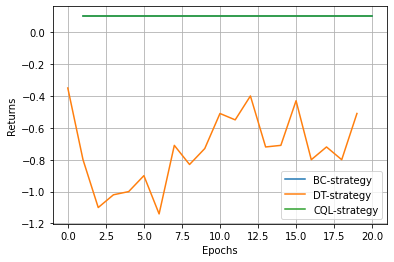

In [26]:
plot_metrics(statistics_bc, "BC-strategy")
plt.plot(dt_statistics[2], label="DT-strategy")
#plot_metrics(statistics_dt, "DT-strategy")
plot_metrics(statistics_cql, "CQL-strategy")
plt.xlabel("Epochs")
plt.ylabel("Returns")
plt.legend()
plt.grid()

# Выводы по offline обучению на эталонных данных

BC и CQL отлично себя показали, получив самые высокие максимально возможное вознаграждение уже на 1-й эпохе. Для этих алгоритмов выбранный seed оказался очень простым. А вот трансформеры и учились дольше тоже кол-во эпох, и не доучились. Видно на графике прирост метрики, но очень медленный. Возможно нужно обучаться дольше, но в эксперименте я ставили одинаковое кол-во шагов для всех алгоритмов, чтобы можно было сравнивать. 


# Часть 2. Обучение offline на смешанных данных

Для того, чтобы данные перестали быть эталонными, нужно добавить к ним данные из рандомно собранного буфера состояний. В d3rlpy есть для этого алгоритм DiscreteRandomPolicyConfig. С помощью него соберем буфер такой же, как и с DQN в 100 000.

In [28]:
# setup algorithm
random_policy = d3rlpy.algos.DiscreteRandomPolicyConfig().create()

# prepare experience replay buffer
random_buffer = d3rlpy.dataset.create_fifo_replay_buffer(limit=100000, env=env)

# start data collection
random_policy.collect(env, random_buffer, n_steps=100000)

2024-04-13 16:54.21 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('float32')], shape=[(49,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2024-04-13 16:54.21 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2024-04-13 16:54.21 [info     ] Action size has been automatically determined. action_size=5
2024-04-13 16:54.21 [debug    ] Building model...             
2024-04-13 16:54.21 [debug    ] Model has been built.         


100%|██████████| 100000/100000 [00:10<00:00, 9660.87it/s]


Проверю, что даст CQL на рандомных данных. Ожидаю, что ничему не научиться агент.

In [30]:
# setup CQL algorithm
cql = d3rlpy.algos.DiscreteCQLConfig().create(device='cuda:0')

# start training
statistics_random = cql.fit(
    random_buffer,
    n_steps=100000,
    n_steps_per_epoch=5000,
    evaluators={
        'environment': d3rlpy.metrics.EnvironmentEvaluator(env),
    },
)

2024-04-13 16:54.54 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(49,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[()]), reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2024-04-13 16:54.54 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20240413165454
2024-04-13 16:54.54 [debug    ] Building models...            
2024-04-13 16:54.54 [debug    ] Models have been built.       
2024-04-13 16:54.54 [info     ] Parameters                     params={'observation_shape': [49], 'action_size': 5, 'config': {'type': 'discrete_cql', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 6.25e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.

Epoch 1/20: 100%|██████████| 5000/5000 [00:23<00:00, 216.43it/s, loss=1.61, td_loss=0.00182, conservative_loss=1.61]


2024-04-13 16:55.17 [info     ] DiscreteCQL_20240413165454: epoch=1 step=5000 epoch=1 metrics={'time_sample_batch': 0.001282930040359497, 'time_algorithm_update': 0.0031655232429504397, 'loss': 1.611336388015747, 'td_loss': 0.0018163457674148958, 'conservative_loss': 1.6095200425863265, 'time_step': 0.00458753662109375, 'environment': -12.79999999999997} step=5000
2024-04-13 16:55.17 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240413165454/model_5000.d3


Epoch 2/20: 100%|██████████| 5000/5000 [00:22<00:00, 217.91it/s, loss=1.61, td_loss=0.00145, conservative_loss=1.61]


2024-04-13 16:55.41 [info     ] DiscreteCQL_20240413165454: epoch=2 step=10000 epoch=2 metrics={'time_sample_batch': 0.0012664531230926514, 'time_algorithm_update': 0.0031559468269348146, 'loss': 1.610761401128769, 'td_loss': 0.0014489647892682114, 'conservative_loss': 1.6093124370336533, 'time_step': 0.004556442451477051, 'environment': -12.79999999999997} step=10000
2024-04-13 16:55.41 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240413165454/model_10000.d3


Epoch 3/20: 100%|██████████| 5000/5000 [00:23<00:00, 216.98it/s, loss=1.61, td_loss=0.000819, conservative_loss=1.61]


2024-04-13 16:56.05 [info     ] DiscreteCQL_20240413165454: epoch=3 step=15000 epoch=3 metrics={'time_sample_batch': 0.0012820873737335206, 'time_algorithm_update': 0.0031596417427062987, 'loss': 1.6100609699010848, 'td_loss': 0.0008184944824432023, 'conservative_loss': 1.6092424749851226, 'time_step': 0.00457607970237732, 'environment': -12.79999999999997} step=15000
2024-04-13 16:56.05 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240413165454/model_15000.d3


Epoch 4/20: 100%|██████████| 5000/5000 [00:22<00:00, 218.90it/s, loss=1.61, td_loss=0.000748, conservative_loss=1.61]


2024-04-13 16:56.28 [info     ] DiscreteCQL_20240413165454: epoch=4 step=20000 epoch=4 metrics={'time_sample_batch': 0.001289214277267456, 'time_algorithm_update': 0.003107036590576172, 'loss': 1.6098531553030013, 'td_loss': 0.0007472819694463396, 'conservative_loss': 1.6091058733463288, 'time_step': 0.00453364839553833, 'environment': -12.79999999999997} step=20000
2024-04-13 16:56.28 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240413165454/model_20000.d3


Epoch 5/20: 100%|██████████| 5000/5000 [00:22<00:00, 220.46it/s, loss=1.61, td_loss=0.000656, conservative_loss=1.61]


2024-04-13 16:56.51 [info     ] DiscreteCQL_20240413165454: epoch=5 step=25000 epoch=5 metrics={'time_sample_batch': 0.00127131667137146, 'time_algorithm_update': 0.0030993421554565428, 'loss': 1.6098734809398652, 'td_loss': 0.0006560308456420898, 'conservative_loss': 1.6092174502134322, 'time_step': 0.004503648948669434, 'environment': -12.79999999999997} step=25000
2024-04-13 16:56.51 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240413165454/model_25000.d3


Epoch 6/20: 100%|██████████| 5000/5000 [00:22<00:00, 224.31it/s, loss=1.61, td_loss=0.000597, conservative_loss=1.61]


2024-04-13 16:57.14 [info     ] DiscreteCQL_20240413165454: epoch=6 step=30000 epoch=6 metrics={'time_sample_batch': 0.0012765401363372803, 'time_algorithm_update': 0.003011863374710083, 'loss': 1.6097573493003845, 'td_loss': 0.0005976342283145641, 'conservative_loss': 1.6091597157478332, 'time_step': 0.004424704694747925, 'environment': -12.79999999999997} step=30000
2024-04-13 16:57.14 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240413165454/model_30000.d3


Epoch 7/20: 100%|██████████| 5000/5000 [00:22<00:00, 222.34it/s, loss=1.61, td_loss=0.000703, conservative_loss=1.61]


2024-04-13 16:57.37 [info     ] DiscreteCQL_20240413165454: epoch=7 step=35000 epoch=7 metrics={'time_sample_batch': 0.0012872071743011474, 'time_algorithm_update': 0.0030384177207946777, 'loss': 1.6098775492191315, 'td_loss': 0.0007030288398382254, 'conservative_loss': 1.6091745213508606, 'time_step': 0.004464091539382935, 'environment': -12.79999999999997} step=35000
2024-04-13 16:57.37 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240413165454/model_35000.d3


Epoch 8/20: 100%|██████████| 5000/5000 [00:23<00:00, 214.53it/s, loss=1.61, td_loss=0.000711, conservative_loss=1.61]


2024-04-13 16:58.01 [info     ] DiscreteCQL_20240413165454: epoch=8 step=40000 epoch=8 metrics={'time_sample_batch': 0.0013260468482971192, 'time_algorithm_update': 0.0031760952472686768, 'loss': 1.6097450616836548, 'td_loss': 0.0007108128378240508, 'conservative_loss': 1.6090342485666276, 'time_step': 0.004631226873397827, 'environment': -12.79999999999997} step=40000
2024-04-13 16:58.01 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240413165454/model_40000.d3


Epoch 9/20: 100%|██████████| 5000/5000 [00:22<00:00, 224.84it/s, loss=1.61, td_loss=0.000895, conservative_loss=1.61]


2024-04-13 16:58.24 [info     ] DiscreteCQL_20240413165454: epoch=9 step=45000 epoch=9 metrics={'time_sample_batch': 0.0012688810348510742, 'time_algorithm_update': 0.0030125686645507813, 'loss': 1.6098989916086197, 'td_loss': 0.000894798262490076, 'conservative_loss': 1.6090041940689086, 'time_step': 0.004415168333053589, 'environment': -12.79999999999997} step=45000
2024-04-13 16:58.24 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240413165454/model_45000.d3


Epoch 10/20: 100%|██████████| 5000/5000 [00:22<00:00, 224.07it/s, loss=1.61, td_loss=0.000848, conservative_loss=1.61]


2024-04-13 16:58.47 [info     ] DiscreteCQL_20240413165454: epoch=10 step=50000 epoch=10 metrics={'time_sample_batch': 0.0012695940971374513, 'time_algorithm_update': 0.003026352262496948, 'loss': 1.6098952137708664, 'td_loss': 0.0008478075030769105, 'conservative_loss': 1.6090474058628081, 'time_step': 0.004430019426345825, 'environment': -12.79999999999997} step=50000
2024-04-13 16:58.47 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240413165454/model_50000.d3


Epoch 11/20: 100%|██████████| 5000/5000 [00:22<00:00, 224.07it/s, loss=1.61, td_loss=0.000775, conservative_loss=1.61]


2024-04-13 16:59.10 [info     ] DiscreteCQL_20240413165454: epoch=11 step=55000 epoch=11 metrics={'time_sample_batch': 0.0012744340896606444, 'time_algorithm_update': 0.0030287942886352537, 'loss': 1.6099076441764832, 'td_loss': 0.0007755078489470179, 'conservative_loss': 1.609132136631012, 'time_step': 0.004431572151184082, 'environment': -12.79999999999997} step=55000
2024-04-13 16:59.10 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240413165454/model_55000.d3


Epoch 12/20: 100%|██████████| 5000/5000 [00:22<00:00, 224.20it/s, loss=1.61, td_loss=0.000902, conservative_loss=1.61]


2024-04-13 16:59.33 [info     ] DiscreteCQL_20240413165454: epoch=12 step=60000 epoch=12 metrics={'time_sample_batch': 0.0012740591526031494, 'time_algorithm_update': 0.003021026134490967, 'loss': 1.609968177318573, 'td_loss': 0.0009026981977192917, 'conservative_loss': 1.609065478539467, 'time_step': 0.004426771545410157, 'environment': -12.79999999999997} step=60000
2024-04-13 16:59.33 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240413165454/model_60000.d3


Epoch 13/20: 100%|██████████| 5000/5000 [00:22<00:00, 224.07it/s, loss=1.61, td_loss=0.000908, conservative_loss=1.61]


2024-04-13 16:59.55 [info     ] DiscreteCQL_20240413165454: epoch=13 step=65000 epoch=13 metrics={'time_sample_batch': 0.0012762587070465087, 'time_algorithm_update': 0.003022252798080444, 'loss': 1.6100345967769623, 'td_loss': 0.0009078805103723425, 'conservative_loss': 1.609126716852188, 'time_step': 0.004432486486434937, 'environment': -12.79999999999997} step=65000
2024-04-13 16:59.55 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240413165454/model_65000.d3


Epoch 14/20: 100%|██████████| 5000/5000 [00:22<00:00, 224.20it/s, loss=1.61, td_loss=0.00101, conservative_loss=1.61] 


2024-04-13 17:00.18 [info     ] DiscreteCQL_20240413165454: epoch=14 step=70000 epoch=14 metrics={'time_sample_batch': 0.001272404670715332, 'time_algorithm_update': 0.00302594051361084, 'loss': 1.610148097705841, 'td_loss': 0.001008680935757002, 'conservative_loss': 1.6091394166707993, 'time_step': 0.004430110692977905, 'environment': -12.79999999999997} step=70000
2024-04-13 17:00.18 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240413165454/model_70000.d3


Epoch 15/20: 100%|██████████| 5000/5000 [00:22<00:00, 221.44it/s, loss=1.61, td_loss=0.00111, conservative_loss=1.61] 


2024-04-13 17:00.41 [info     ] DiscreteCQL_20240413165454: epoch=15 step=75000 epoch=15 metrics={'time_sample_batch': 0.0012938177585601807, 'time_algorithm_update': 0.0030563201904296876, 'loss': 1.610258422112465, 'td_loss': 0.0011113116453692782, 'conservative_loss': 1.6091471110105515, 'time_step': 0.004484964561462403, 'environment': -12.79999999999997} step=75000
2024-04-13 17:00.41 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240413165454/model_75000.d3


Epoch 16/20: 100%|██████████| 5000/5000 [00:22<00:00, 223.22it/s, loss=1.61, td_loss=0.00114, conservative_loss=1.61]


2024-04-13 17:01.04 [info     ] DiscreteCQL_20240413165454: epoch=16 step=80000 epoch=16 metrics={'time_sample_batch': 0.0012825918674468995, 'time_algorithm_update': 0.0030324233055114744, 'loss': 1.61033032310009, 'td_loss': 0.0011410660937763168, 'conservative_loss': 1.6091892565250396, 'time_step': 0.0044501520156860356, 'environment': -12.79999999999997} step=80000
2024-04-13 17:01.04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240413165454/model_80000.d3


Epoch 17/20: 100%|██████████| 5000/5000 [00:22<00:00, 221.05it/s, loss=1.61, td_loss=0.00123, conservative_loss=1.61]


2024-04-13 17:01.28 [info     ] DiscreteCQL_20240413165454: epoch=17 step=85000 epoch=17 metrics={'time_sample_batch': 0.0013181330680847169, 'time_algorithm_update': 0.0030347352504730223, 'loss': 1.6102489732027054, 'td_loss': 0.0012266293994733133, 'conservative_loss': 1.6090223439216613, 'time_step': 0.004492920160293579, 'environment': -12.79999999999997} step=85000
2024-04-13 17:01.28 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240413165454/model_85000.d3


Epoch 18/20: 100%|██████████| 5000/5000 [00:22<00:00, 220.62it/s, loss=1.61, td_loss=0.00132, conservative_loss=1.61]


2024-04-13 17:01.51 [info     ] DiscreteCQL_20240413165454: epoch=18 step=90000 epoch=18 metrics={'time_sample_batch': 0.0012759193420410157, 'time_algorithm_update': 0.003092313766479492, 'loss': 1.6105743696928023, 'td_loss': 0.001320043244517001, 'conservative_loss': 1.6092543270111084, 'time_step': 0.004500865268707276, 'environment': -12.79999999999997} step=90000
2024-04-13 17:01.51 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240413165454/model_90000.d3


Epoch 19/20: 100%|██████████| 5000/5000 [00:23<00:00, 215.95it/s, loss=1.61, td_loss=0.00136, conservative_loss=1.61]


2024-04-13 17:02.15 [info     ] DiscreteCQL_20240413165454: epoch=19 step=95000 epoch=19 metrics={'time_sample_batch': 0.0012822807312011719, 'time_algorithm_update': 0.003178291416168213, 'loss': 1.6106890213489533, 'td_loss': 0.0013617497797851683, 'conservative_loss': 1.609327271080017, 'time_step': 0.00459699330329895, 'environment': -12.79999999999997} step=95000
2024-04-13 17:02.15 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240413165454/model_95000.d3


Epoch 20/20: 100%|██████████| 5000/5000 [00:23<00:00, 215.99it/s, loss=1.61, td_loss=0.00147, conservative_loss=1.61]


2024-04-13 17:02.38 [info     ] DiscreteCQL_20240413165454: epoch=20 step=100000 epoch=20 metrics={'time_sample_batch': 0.001275821304321289, 'time_algorithm_update': 0.0031845245838165283, 'loss': 1.6109577335596084, 'td_loss': 0.001468603087020165, 'conservative_loss': 1.609489130449295, 'time_step': 0.004597275543212891, 'environment': -12.79999999999997} step=100000
2024-04-13 17:02.38 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240413165454/model_100000.d3


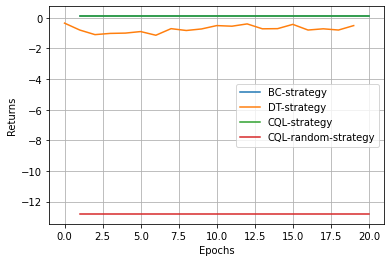

In [31]:
plot_metrics(statistics_bc, "BC-strategy")
plt.plot(dt_statistics[2], label="DT-strategy")
plot_metrics(statistics_cql, "CQL-strategy")
plot_metrics(statistics_random, "CQL-random-strategy")
plt.xlabel("Epochs")
plt.ylabel("Returns")
plt.legend()
plt.grid()

Вполне ожидаемо, агент вообще не учится, а только выбирает полные штрафы. Скорее всего он стоит на месте, не приближаясь к цели.

# Cоздание mixed dataset

Воспользуюсь предложенными на занятии функциями, чтобы замиксовать полученные DQN и случайный буферы.Пропорцию возьму 6:4, где 60% будет эталонных данных и 40% рандомных.

In [33]:
def dataset_cooker(buffer, size):
  observations = []
  actions = []
  rewards = []
  terminals = []

  for episode in buffer.episodes[:size]:
    observations+=episode.observations.tolist()
    actions += episode.actions.tolist()
    rewards += episode.rewards.tolist()

    terminal = [0 for _ in range(len(episode.rewards))]
    terminal[-1] = 1
    terminals += terminal
  return observations, actions, rewards, terminals

def make_mixed_dataset(dataset_1, dataset_2, proportions = [1,1]):
  size_1 = int(len(dataset_1.episodes) * proportions[0])
  size_2 = int(len(dataset_2.episodes) * proportions[1])

  observations, actions, rewards, terminals = dataset_cooker(dataset_1, size_1)

  rnd_observations, rnd_actions, rnd_rewards, rnd_terminals = dataset_cooker(dataset_2, size_2)

  mxt_obs = np.asarray(observations+rnd_observations)
  mxt_actions = np.asarray(actions+rnd_actions)
  mxt_rewards = np.asarray(rewards+rnd_rewards)
  mxt_terminals = np.asarray(terminals+rnd_terminals).reshape(-1,1)

  mixed_dataset = d3rlpy.dataset.MDPDataset(
    observations=mxt_obs,
    actions=mxt_actions,
    rewards=mxt_rewards,
    terminals=mxt_terminals,
  )
  return mixed_dataset

mixed_dataset = make_mixed_dataset(dqn_buffer, random_buffer, (0.6, 0.4))

2024-04-13 17:04.51 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]) observation_signature=Signature(dtype=[dtype('float64')], shape=[(49,)]) reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)])
2024-04-13 17:04.51 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2024-04-13 17:04.51 [info     ] Action size has been automatically determined. action_size=5


Датасет получен, запускаем на нем обучение агентов. Я заново инициализирую все алгоритмы. Все параметры как и в предыдущем варианте, меняю только датасет.

# BC на смешанных данных

In [34]:
bc = d3rlpy.algos.DiscreteBCConfig(learning_rate=0.0001, gamma=0.9).create(device='cuda:0')

# start training
statistics_bc_mixed = bc.fit(
    mixed_dataset,
    n_steps=100000,
    n_steps_per_epoch=5000,
    evaluators={
        'environment': d3rlpy.metrics.EnvironmentEvaluator(env),
    },
)

2024-04-13 17:05.03 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(49,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2024-04-13 17:05.03 [info     ] Directory is created at d3rlpy_logs/DiscreteBC_20240413170503
2024-04-13 17:05.03 [debug    ] Building models...            
2024-04-13 17:05.03 [debug    ] Models have been built.       
2024-04-13 17:05.03 [info     ] Parameters                     params={'observation_shape': [49], 'action_size': 5, 'config': {'type': 'discrete_bc', 'params': {'batch_size': 100, 'gamma': 0.9, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 0.0001, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9

Epoch 1/20: 100%|██████████| 5000/5000 [00:22<00:00, 221.16it/s, loss=2.85]


2024-04-13 17:05.26 [info     ] DiscreteBC_20240413170503: epoch=1 step=5000 epoch=1 metrics={'time_sample_batch': 0.002787867069244385, 'time_algorithm_update': 0.0016227513313293457, 'loss': 2.850229079389572, 'time_step': 0.004495411729812622, 'environment': 0.10000000000000009} step=5000
2024-04-13 17:05.26 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240413170503/model_5000.d3


Epoch 2/20: 100%|██████████| 5000/5000 [00:22<00:00, 222.85it/s, loss=2.85]


2024-04-13 17:05.48 [info     ] DiscreteBC_20240413170503: epoch=2 step=10000 epoch=2 metrics={'time_sample_batch': 0.002761070156097412, 'time_algorithm_update': 0.0016171651840209962, 'loss': 2.848989819955826, 'time_step': 0.004461053466796875, 'environment': 0.10000000000000009} step=10000
2024-04-13 17:05.48 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240413170503/model_10000.d3


Epoch 3/20: 100%|██████████| 5000/5000 [00:22<00:00, 220.72it/s, loss=2.85]


2024-04-13 17:06.11 [info     ] DiscreteBC_20240413170503: epoch=3 step=15000 epoch=3 metrics={'time_sample_batch': 0.002810080099105835, 'time_algorithm_update': 0.001609259557723999, 'loss': 2.848515619182587, 'time_step': 0.004503978824615479, 'environment': 0.10000000000000009} step=15000
2024-04-13 17:06.11 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240413170503/model_15000.d3


Epoch 4/20: 100%|██████████| 5000/5000 [00:22<00:00, 225.67it/s, loss=2.85]


2024-04-13 17:06.33 [info     ] DiscreteBC_20240413170503: epoch=4 step=20000 epoch=4 metrics={'time_sample_batch': 0.0027529052734375, 'time_algorithm_update': 0.0015674692630767823, 'loss': 2.848307624435425, 'time_step': 0.004404711866378784, 'environment': 0.10000000000000009} step=20000
2024-04-13 17:06.33 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240413170503/model_20000.d3


Epoch 5/20: 100%|██████████| 5000/5000 [00:22<00:00, 225.75it/s, loss=2.85]


2024-04-13 17:06.56 [info     ] DiscreteBC_20240413170503: epoch=5 step=25000 epoch=5 metrics={'time_sample_batch': 0.0027496774196624756, 'time_algorithm_update': 0.001569417381286621, 'loss': 2.8483373676776886, 'time_step': 0.004402998828887939, 'environment': 0.10000000000000009} step=25000
2024-04-13 17:06.56 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240413170503/model_25000.d3


Epoch 6/20: 100%|██████████| 5000/5000 [00:22<00:00, 225.00it/s, loss=2.85]


2024-04-13 17:07.18 [info     ] DiscreteBC_20240413170503: epoch=6 step=30000 epoch=6 metrics={'time_sample_batch': 0.002756290102005005, 'time_algorithm_update': 0.0015756348133087157, 'loss': 2.8489962872982026, 'time_step': 0.00441752610206604, 'environment': 0.10000000000000009} step=30000
2024-04-13 17:07.18 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240413170503/model_30000.d3


Epoch 7/20: 100%|██████████| 5000/5000 [00:22<00:00, 225.15it/s, loss=2.85]


2024-04-13 17:07.40 [info     ] DiscreteBC_20240413170503: epoch=7 step=35000 epoch=7 metrics={'time_sample_batch': 0.0027563556671142578, 'time_algorithm_update': 0.0015731868267059325, 'loss': 2.8485408601284026, 'time_step': 0.004414591789245605, 'environment': 0.10000000000000009} step=35000
2024-04-13 17:07.40 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240413170503/model_35000.d3


Epoch 8/20: 100%|██████████| 5000/5000 [00:22<00:00, 223.30it/s, loss=2.85]


2024-04-13 17:08.03 [info     ] DiscreteBC_20240413170503: epoch=8 step=40000 epoch=8 metrics={'time_sample_batch': 0.002774560546875, 'time_algorithm_update': 0.0015921828269958496, 'loss': 2.8481331932067873, 'time_step': 0.004451744890213012, 'environment': 0.10000000000000009} step=40000
2024-04-13 17:08.03 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240413170503/model_40000.d3


Epoch 9/20: 100%|██████████| 5000/5000 [00:22<00:00, 221.54it/s, loss=2.85]


2024-04-13 17:08.25 [info     ] DiscreteBC_20240413170503: epoch=9 step=45000 epoch=9 metrics={'time_sample_batch': 0.0027871456623077395, 'time_algorithm_update': 0.0016156334400177002, 'loss': 2.8481186565876007, 'time_step': 0.004488012933731079, 'environment': 0.10000000000000009} step=45000
2024-04-13 17:08.26 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240413170503/model_45000.d3


Epoch 10/20: 100%|██████████| 5000/5000 [00:22<00:00, 223.44it/s, loss=2.85]


2024-04-13 17:08.48 [info     ] DiscreteBC_20240413170503: epoch=10 step=50000 epoch=10 metrics={'time_sample_batch': 0.002768796157836914, 'time_algorithm_update': 0.0015939855575561523, 'loss': 2.8484073784351347, 'time_step': 0.004448746299743653, 'environment': 0.10000000000000009} step=50000
2024-04-13 17:08.48 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240413170503/model_50000.d3


Epoch 11/20: 100%|██████████| 5000/5000 [00:22<00:00, 221.72it/s, loss=2.85]


2024-04-13 17:09.11 [info     ] DiscreteBC_20240413170503: epoch=11 step=55000 epoch=11 metrics={'time_sample_batch': 0.0027247058868408204, 'time_algorithm_update': 0.0016769152164459228, 'loss': 2.8483545568466186, 'time_step': 0.004484386062622071, 'environment': 0.10000000000000009} step=55000
2024-04-13 17:09.11 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240413170503/model_55000.d3


Epoch 12/20: 100%|██████████| 5000/5000 [00:22<00:00, 221.12it/s, loss=2.85]


2024-04-13 17:09.33 [info     ] DiscreteBC_20240413170503: epoch=12 step=60000 epoch=12 metrics={'time_sample_batch': 0.0027412184715270996, 'time_algorithm_update': 0.001672075366973877, 'loss': 2.8486907987594603, 'time_step': 0.004497154760360718, 'environment': 0.10000000000000009} step=60000
2024-04-13 17:09.33 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240413170503/model_60000.d3


Epoch 13/20: 100%|██████████| 5000/5000 [00:22<00:00, 221.38it/s, loss=2.85]


2024-04-13 17:09.56 [info     ] DiscreteBC_20240413170503: epoch=13 step=65000 epoch=13 metrics={'time_sample_batch': 0.002804599905014038, 'time_algorithm_update': 0.0016005216121673584, 'loss': 2.8476984389781954, 'time_step': 0.004490251874923706, 'environment': 0.10000000000000009} step=65000
2024-04-13 17:09.56 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240413170503/model_65000.d3


Epoch 14/20: 100%|██████████| 5000/5000 [00:22<00:00, 222.21it/s, loss=2.85]


2024-04-13 17:10.19 [info     ] DiscreteBC_20240413170503: epoch=14 step=70000 epoch=14 metrics={'time_sample_batch': 0.0027835895538330076, 'time_algorithm_update': 0.0015993468284606935, 'loss': 2.8478823103427886, 'time_step': 0.0044730969905853275, 'environment': 0.10000000000000009} step=70000
2024-04-13 17:10.19 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240413170503/model_70000.d3


Epoch 15/20: 100%|██████████| 5000/5000 [00:23<00:00, 217.25it/s, loss=2.85]


2024-04-13 17:10.42 [info     ] DiscreteBC_20240413170503: epoch=15 step=75000 epoch=15 metrics={'time_sample_batch': 0.002857474136352539, 'time_algorithm_update': 0.0016278298377990722, 'loss': 2.8479629631996155, 'time_step': 0.004575359487533569, 'environment': 0.10000000000000009} step=75000
2024-04-13 17:10.42 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240413170503/model_75000.d3


Epoch 16/20: 100%|██████████| 5000/5000 [00:23<00:00, 217.30it/s, loss=2.85]


2024-04-13 17:11.05 [info     ] DiscreteBC_20240413170503: epoch=16 step=80000 epoch=16 metrics={'time_sample_batch': 0.002851757049560547, 'time_algorithm_update': 0.0016310146808624268, 'loss': 2.848487199020386, 'time_step': 0.004574030113220215, 'environment': 0.10000000000000009} step=80000
2024-04-13 17:11.05 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240413170503/model_80000.d3


Epoch 17/20: 100%|██████████| 5000/5000 [00:22<00:00, 223.05it/s, loss=2.85]


2024-04-13 17:11.27 [info     ] DiscreteBC_20240413170503: epoch=17 step=85000 epoch=17 metrics={'time_sample_batch': 0.0027663068294525145, 'time_algorithm_update': 0.001602604293823242, 'loss': 2.848337887430191, 'time_step': 0.004456007432937622, 'environment': 0.10000000000000009} step=85000
2024-04-13 17:11.27 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240413170503/model_85000.d3


Epoch 18/20: 100%|██████████| 5000/5000 [00:22<00:00, 223.36it/s, loss=2.85]


2024-04-13 17:11.50 [info     ] DiscreteBC_20240413170503: epoch=18 step=90000 epoch=18 metrics={'time_sample_batch': 0.002763813877105713, 'time_algorithm_update': 0.0015998419761657715, 'loss': 2.8481949031829834, 'time_step': 0.004449819374084472, 'environment': 0.10000000000000009} step=90000
2024-04-13 17:11.50 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240413170503/model_90000.d3


Epoch 19/20: 100%|██████████| 5000/5000 [00:22<00:00, 223.46it/s, loss=2.85]


2024-04-13 17:12.12 [info     ] DiscreteBC_20240413170503: epoch=19 step=95000 epoch=19 metrics={'time_sample_batch': 0.0027640575408935547, 'time_algorithm_update': 0.0015998125553131103, 'loss': 2.8485290780067443, 'time_step': 0.004448326539993286, 'environment': 0.10000000000000009} step=95000
2024-04-13 17:12.12 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240413170503/model_95000.d3


Epoch 20/20: 100%|██████████| 5000/5000 [00:22<00:00, 223.32it/s, loss=2.85]


2024-04-13 17:12.35 [info     ] DiscreteBC_20240413170503: epoch=20 step=100000 epoch=20 metrics={'time_sample_batch': 0.00276606707572937, 'time_algorithm_update': 0.0015997697353363038, 'loss': 2.8478954959869385, 'time_step': 0.004450776958465576, 'environment': 0.10000000000000009} step=100000
2024-04-13 17:12.35 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteBC_20240413170503/model_100000.d3


# CQL на смешанных данных

In [35]:
# setup CQL algorithm
cql = d3rlpy.algos.DiscreteCQLConfig().create(device='cuda:0')

# start training
statistics_cql_mixed = cql.fit(
    mixed_dataset,
    n_steps=100000,
    n_steps_per_epoch=5000,
    evaluators={
        'environment': d3rlpy.metrics.EnvironmentEvaluator(env),
    },
)

2024-04-13 17:12.56 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(49,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2024-04-13 17:12.56 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20240413171256
2024-04-13 17:12.56 [debug    ] Building models...            
2024-04-13 17:12.56 [debug    ] Models have been built.       
2024-04-13 17:12.56 [info     ] Parameters                     params={'observation_shape': [49], 'action_size': 5, 'config': {'type': 'discrete_cql', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 6.25e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': 

Epoch 1/20: 100%|██████████| 5000/5000 [00:20<00:00, 242.05it/s, loss=1.53, td_loss=0.0405, conservative_loss=1.49]


2024-04-13 17:13.17 [info     ] DiscreteCQL_20240413171256: epoch=1 step=5000 epoch=1 metrics={'time_sample_batch': 0.0009712770462036133, 'time_algorithm_update': 0.0029947724342346193, 'loss': 1.531257022213936, 'td_loss': 0.04045053100227378, 'conservative_loss': 1.490806491422653, 'time_step': 0.004099686431884766, 'environment': 0.10000000000000009} step=5000
2024-04-13 17:13.17 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240413171256/model_5000.d3


Epoch 2/20: 100%|██████████| 5000/5000 [00:20<00:00, 243.92it/s, loss=1.52, td_loss=0.0444, conservative_loss=1.48]


2024-04-13 17:13.37 [info     ] DiscreteCQL_20240413171256: epoch=2 step=10000 epoch=2 metrics={'time_sample_batch': 0.0009639089107513428, 'time_algorithm_update': 0.0029782519340515136, 'loss': 1.520940544128418, 'td_loss': 0.04442876111902296, 'conservative_loss': 1.4765117830276488, 'time_step': 0.004069055032730103, 'environment': 0.10000000000000009} step=10000
2024-04-13 17:13.37 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240413171256/model_10000.d3


Epoch 3/20: 100%|██████████| 5000/5000 [00:20<00:00, 242.77it/s, loss=1.51, td_loss=0.04, conservative_loss=1.47]  


2024-04-13 17:13.58 [info     ] DiscreteCQL_20240413171256: epoch=3 step=15000 epoch=3 metrics={'time_sample_batch': 0.0009686900615692138, 'time_algorithm_update': 0.0029858521461486815, 'loss': 1.5142977035045624, 'td_loss': 0.03998472733311355, 'conservative_loss': 1.474312975549698, 'time_step': 0.004087112331390381, 'environment': 0.10000000000000009} step=15000
2024-04-13 17:13.58 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240413171256/model_15000.d3


Epoch 4/20: 100%|██████████| 5000/5000 [00:20<00:00, 243.07it/s, loss=1.51, td_loss=0.0407, conservative_loss=1.47]


2024-04-13 17:14.19 [info     ] DiscreteCQL_20240413171256: epoch=4 step=20000 epoch=4 metrics={'time_sample_batch': 0.0009694646835327149, 'time_algorithm_update': 0.002980721664428711, 'loss': 1.5129323682785034, 'td_loss': 0.040653022149577736, 'conservative_loss': 1.4722793456554413, 'time_step': 0.0040825987815856935, 'environment': 0.10000000000000009} step=20000
2024-04-13 17:14.19 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240413171256/model_20000.d3


Epoch 5/20: 100%|██████████| 5000/5000 [00:20<00:00, 243.87it/s, loss=1.51, td_loss=0.0395, conservative_loss=1.47]


2024-04-13 17:14.39 [info     ] DiscreteCQL_20240413171256: epoch=5 step=25000 epoch=5 metrics={'time_sample_batch': 0.0009663794994354248, 'time_algorithm_update': 0.0029732683658599854, 'loss': 1.5117296393632889, 'td_loss': 0.0394701109547168, 'conservative_loss': 1.4722595281362534, 'time_step': 0.0040700254440307615, 'environment': 0.10000000000000009} step=25000
2024-04-13 17:14.39 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240413171256/model_25000.d3


Epoch 6/20: 100%|██████████| 5000/5000 [00:20<00:00, 243.20it/s, loss=1.51, td_loss=0.0391, conservative_loss=1.47]


2024-04-13 17:15.00 [info     ] DiscreteCQL_20240413171256: epoch=6 step=30000 epoch=6 metrics={'time_sample_batch': 0.0009666520595550537, 'time_algorithm_update': 0.0029826093673706055, 'loss': 1.509838224864006, 'td_loss': 0.03909129047952593, 'conservative_loss': 1.4707469352483749, 'time_step': 0.004080645418167115, 'environment': 0.10000000000000009} step=30000
2024-04-13 17:15.00 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240413171256/model_30000.d3


Epoch 7/20: 100%|██████████| 5000/5000 [00:21<00:00, 237.76it/s, loss=1.51, td_loss=0.0409, conservative_loss=1.47]


2024-04-13 17:15.21 [info     ] DiscreteCQL_20240413171256: epoch=7 step=35000 epoch=7 metrics={'time_sample_batch': 0.0009800507545471191, 'time_algorithm_update': 0.00305852952003479, 'loss': 1.5131954557418823, 'td_loss': 0.04092663439661264, 'conservative_loss': 1.4722688216209412, 'time_step': 0.004173424577713013, 'environment': 0.10000000000000009} step=35000
2024-04-13 17:15.21 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240413171256/model_35000.d3


Epoch 8/20: 100%|██████████| 5000/5000 [00:21<00:00, 232.32it/s, loss=1.51, td_loss=0.0414, conservative_loss=1.47]


2024-04-13 17:15.43 [info     ] DiscreteCQL_20240413171256: epoch=8 step=40000 epoch=8 metrics={'time_sample_batch': 0.00098561749458313, 'time_algorithm_update': 0.0031494510173797606, 'loss': 1.513290172791481, 'td_loss': 0.041438425106741485, 'conservative_loss': 1.471851748251915, 'time_step': 0.004271210765838623, 'environment': 0.10000000000000009} step=40000
2024-04-13 17:15.43 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240413171256/model_40000.d3


Epoch 9/20: 100%|██████████| 5000/5000 [00:21<00:00, 232.76it/s, loss=1.52, td_loss=0.0443, conservative_loss=1.48]


2024-04-13 17:16.04 [info     ] DiscreteCQL_20240413171256: epoch=9 step=45000 epoch=9 metrics={'time_sample_batch': 0.0009839345455169679, 'time_algorithm_update': 0.003143380117416382, 'loss': 1.5215503067016602, 'td_loss': 0.044240982486307624, 'conservative_loss': 1.4773093249559401, 'time_step': 0.004263213872909546, 'environment': 0.10000000000000009} step=45000
2024-04-13 17:16.04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240413171256/model_45000.d3


Epoch 10/20: 100%|██████████| 5000/5000 [00:21<00:00, 231.97it/s, loss=1.52, td_loss=0.0453, conservative_loss=1.48]


2024-04-13 17:16.26 [info     ] DiscreteCQL_20240413171256: epoch=10 step=50000 epoch=10 metrics={'time_sample_batch': 0.0009899716377258301, 'time_algorithm_update': 0.003151001787185669, 'loss': 1.5223357257843018, 'td_loss': 0.04527049422040582, 'conservative_loss': 1.4770652316570283, 'time_step': 0.004277113628387451, 'environment': 0.10000000000000009} step=50000
2024-04-13 17:16.26 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240413171256/model_50000.d3


Epoch 11/20: 100%|██████████| 5000/5000 [00:21<00:00, 233.97it/s, loss=1.52, td_loss=0.0468, conservative_loss=1.48]


2024-04-13 17:16.47 [info     ] DiscreteCQL_20240413171256: epoch=11 step=55000 epoch=11 metrics={'time_sample_batch': 0.0009805289268493653, 'time_algorithm_update': 0.003124603176116943, 'loss': 1.5222606471061706, 'td_loss': 0.046830162427201866, 'conservative_loss': 1.4754304845571518, 'time_step': 0.004240386104583741, 'environment': 0.10000000000000009} step=55000
2024-04-13 17:16.47 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240413171256/model_55000.d3


Epoch 12/20: 100%|██████████| 5000/5000 [00:20<00:00, 243.43it/s, loss=1.53, td_loss=0.0494, conservative_loss=1.48]


2024-04-13 17:17.08 [info     ] DiscreteCQL_20240413171256: epoch=12 step=60000 epoch=12 metrics={'time_sample_batch': 0.0009606705665588379, 'time_algorithm_update': 0.0029840718746185304, 'loss': 1.5289561302900314, 'td_loss': 0.049417598740011455, 'conservative_loss': 1.4795385311365128, 'time_step': 0.004075976133346558, 'environment': 0.10000000000000009} step=60000
2024-04-13 17:17.08 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240413171256/model_60000.d3


Epoch 13/20: 100%|██████████| 5000/5000 [00:20<00:00, 244.23it/s, loss=1.53, td_loss=0.0506, conservative_loss=1.48]


2024-04-13 17:17.28 [info     ] DiscreteCQL_20240413171256: epoch=13 step=65000 epoch=13 metrics={'time_sample_batch': 0.0009585498332977295, 'time_algorithm_update': 0.002986742830276489, 'loss': 1.5299733949899674, 'td_loss': 0.05054330556318164, 'conservative_loss': 1.4794300897598267, 'time_step': 0.004067367362976074, 'environment': 0.10000000000000009} step=65000
2024-04-13 17:17.28 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240413171256/model_65000.d3


Epoch 14/20: 100%|██████████| 5000/5000 [00:20<00:00, 239.14it/s, loss=1.54, td_loss=0.0529, conservative_loss=1.48]


2024-04-13 17:17.49 [info     ] DiscreteCQL_20240413171256: epoch=14 step=70000 epoch=14 metrics={'time_sample_batch': 0.0009917377948760987, 'time_algorithm_update': 0.0030246557712554933, 'loss': 1.5355710573911667, 'td_loss': 0.05285729450881481, 'conservative_loss': 1.4827137628555298, 'time_step': 0.004151329231262207, 'environment': 0.10000000000000009} step=70000
2024-04-13 17:17.49 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240413171256/model_70000.d3


Epoch 15/20: 100%|██████████| 5000/5000 [00:21<00:00, 235.97it/s, loss=1.54, td_loss=0.0549, conservative_loss=1.48]


2024-04-13 17:18.11 [info     ] DiscreteCQL_20240413171256: epoch=15 step=75000 epoch=15 metrics={'time_sample_batch': 0.0009727768898010254, 'time_algorithm_update': 0.0030894055366516115, 'loss': 1.53887071287632, 'td_loss': 0.05489844842478633, 'conservative_loss': 1.4839722636222838, 'time_step': 0.004204746532440185, 'environment': 0.10000000000000009} step=75000
2024-04-13 17:18.11 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240413171256/model_75000.d3


Epoch 16/20: 100%|██████████| 5000/5000 [00:20<00:00, 239.07it/s, loss=1.54, td_loss=0.0564, conservative_loss=1.49]


2024-04-13 17:18.32 [info     ] DiscreteCQL_20240413171256: epoch=16 step=80000 epoch=16 metrics={'time_sample_batch': 0.0009770940780639648, 'time_algorithm_update': 0.0030325053215026856, 'loss': 1.541472202706337, 'td_loss': 0.05641527144424617, 'conservative_loss': 1.4850569309949875, 'time_step': 0.004148747396469117, 'environment': 0.10000000000000009} step=80000
2024-04-13 17:18.32 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240413171256/model_80000.d3


Epoch 17/20: 100%|██████████| 5000/5000 [00:20<00:00, 242.51it/s, loss=1.55, td_loss=0.0592, conservative_loss=1.49]


2024-04-13 17:18.53 [info     ] DiscreteCQL_20240413171256: epoch=17 step=85000 epoch=17 metrics={'time_sample_batch': 0.0009676309585571289, 'time_algorithm_update': 0.002991536283493042, 'loss': 1.547865938806534, 'td_loss': 0.059149441136419775, 'conservative_loss': 1.4887164982557297, 'time_step': 0.004092388486862182, 'environment': 0.10000000000000009} step=85000
2024-04-13 17:18.53 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240413171256/model_85000.d3


Epoch 18/20: 100%|██████████| 5000/5000 [00:20<00:00, 243.73it/s, loss=1.55, td_loss=0.0615, conservative_loss=1.49]


2024-04-13 17:19.13 [info     ] DiscreteCQL_20240413171256: epoch=18 step=90000 epoch=18 metrics={'time_sample_batch': 0.0009598182678222656, 'time_algorithm_update': 0.002980598020553589, 'loss': 1.5483189237594603, 'td_loss': 0.06145000171922147, 'conservative_loss': 1.4868689217329025, 'time_step': 0.004071393060684204, 'environment': 0.10000000000000009} step=90000
2024-04-13 17:19.13 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240413171256/model_90000.d3


Epoch 19/20: 100%|██████████| 5000/5000 [00:20<00:00, 243.34it/s, loss=1.55, td_loss=0.0624, conservative_loss=1.49]


2024-04-13 17:19.34 [info     ] DiscreteCQL_20240413171256: epoch=19 step=95000 epoch=19 metrics={'time_sample_batch': 0.0009609932899475097, 'time_algorithm_update': 0.002985897445678711, 'loss': 1.5534190591573716, 'td_loss': 0.062399016108736396, 'conservative_loss': 1.4910200431108476, 'time_step': 0.004077557325363159, 'environment': 0.10000000000000009} step=95000
2024-04-13 17:19.34 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240413171256/model_95000.d3


Epoch 20/20: 100%|██████████| 5000/5000 [00:20<00:00, 242.69it/s, loss=1.56, td_loss=0.066, conservative_loss=1.49] 


2024-04-13 17:19.54 [info     ] DiscreteCQL_20240413171256: epoch=20 step=100000 epoch=20 metrics={'time_sample_batch': 0.0009638972282409668, 'time_algorithm_update': 0.002992976522445679, 'loss': 1.5570721309423448, 'td_loss': 0.06602580439150334, 'conservative_loss': 1.4910463263750076, 'time_step': 0.004088831615447998, 'environment': 0.10000000000000009} step=100000
2024-04-13 17:19.54 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240413171256/model_100000.d3


# DT на смешанных данных

In [36]:
dt = d3rlpy.algos.DiscreteDecisionTransformerConfig().create(device="cuda:0")

# offline training
statistics_dt_mixed = dt.fit(
   mixed_dataset,
   n_steps=100000,
   n_steps_per_epoch=5000,
   eval_env=env,
   eval_target_return=0,
   # manually specify action-sampler
   eval_action_sampler=d3rlpy.algos.SoftmaxTransformerActionSampler(),
)

2024-04-13 17:20.09 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(49,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2024-04-13 17:20.09 [info     ] Directory is created at d3rlpy_logs/DiscreteDecisionTransformer_20240413172009
2024-04-13 17:20.09 [debug    ] Building models...            
2024-04-13 17:20.09 [debug    ] Models have been built.       
2024-04-13 17:20.09 [info     ] Parameters                     params={'observation_shape': [49], 'action_size': 5, 'config': {'type': 'discrete_decision_transformer', 'params': {'batch_size': 128, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'context_size': 20, 'max_timestep': 1000, 'lear

Epoch 1/20: 100%|██████████| 5000/5000 [03:32<00:00, 23.55it/s, loss=1.04, learning_rate=0.000553]


2024-04-13 17:23.43 [info     ] DiscreteDecisionTransformer_20240413172009: epoch=1 step=5000 epoch=1 metrics={'time_sample_batch': 0.0059661354064941404, 'time_algorithm_update': 0.036083348894119266, 'loss': 1.0414518904209138, 'learning_rate': 0.0005528570493799698, 'time_step': 0.042204535007476805, 'environment': -0.1299999999999999} step=5000
2024-04-13 17:23.44 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteDecisionTransformer_20240413172009/model_5000.d3


Epoch 2/20: 100%|██████████| 5000/5000 [03:33<00:00, 23.43it/s, loss=1.01, learning_rate=0.000323]


2024-04-13 17:27.22 [info     ] DiscreteDecisionTransformer_20240413172009: epoch=2 step=10000 epoch=2 metrics={'time_sample_batch': 0.005909039545059204, 'time_algorithm_update': 0.03635057015419006, 'loss': 1.0067791234254837, 'learning_rate': 0.0003231948406269756, 'time_step': 0.04242621726989746, 'environment': -0.5299999999999999} step=10000
2024-04-13 17:27.22 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteDecisionTransformer_20240413172009/model_10000.d3


Epoch 3/20: 100%|██████████| 5000/5000 [03:34<00:00, 23.35it/s, loss=0.948, learning_rate=8.84e-5] 


2024-04-13 17:31.02 [info     ] DiscreteDecisionTransformer_20240413172009: epoch=3 step=15000 epoch=3 metrics={'time_sample_batch': 0.005945569896697998, 'time_algorithm_update': 0.036428567790985106, 'loss': 0.9479875985145569, 'learning_rate': 8.836382954137516e-05, 'time_step': 0.042543669509887694, 'environment': -0.7099999999999997} step=15000
2024-04-13 17:31.02 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteDecisionTransformer_20240413172009/model_15000.d3


Epoch 4/20: 100%|██████████| 5000/5000 [03:34<00:00, 23.35it/s, loss=0.911, learning_rate=6.35e-5]


2024-04-13 17:34.42 [info     ] DiscreteDecisionTransformer_20240413172009: epoch=4 step=20000 epoch=4 metrics={'time_sample_batch': 0.005929696702957153, 'time_algorithm_update': 0.03643626618385315, 'loss': 0.9106450942516326, 'learning_rate': 6.359018580324863e-05, 'time_step': 0.04253561329841614, 'environment': -0.9999999999999998} step=20000
2024-04-13 17:34.42 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteDecisionTransformer_20240413172009/model_20000.d3


Epoch 5/20: 100%|██████████| 5000/5000 [03:34<00:00, 23.34it/s, loss=0.875, learning_rate=0.000232]


2024-04-13 17:38.22 [info     ] DiscreteDecisionTransformer_20240413172009: epoch=5 step=25000 epoch=5 metrics={'time_sample_batch': 0.00595489010810852, 'time_algorithm_update': 0.03644158067703247, 'loss': 0.8751342185139656, 'learning_rate': 0.0002319404220977309, 'time_step': 0.04256297845840454, 'environment': -0.8099999999999998} step=25000
2024-04-13 17:38.22 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteDecisionTransformer_20240413172009/model_25000.d3


Epoch 6/20: 100%|██████████| 5000/5000 [03:33<00:00, 23.37it/s, loss=0.768, learning_rate=0.000497]


2024-04-13 17:42.01 [info     ] DiscreteDecisionTransformer_20240413172009: epoch=6 step=30000 epoch=6 metrics={'time_sample_batch': 0.005921438598632813, 'time_algorithm_update': 0.036404494905471804, 'loss': 0.767811245393753, 'learning_rate': 0.0004974324653356836, 'time_step': 0.04249953589439392, 'environment': -0.49999999999999983} step=30000
2024-04-13 17:42.01 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteDecisionTransformer_20240413172009/model_30000.d3


Epoch 7/20: 100%|██████████| 5000/5000 [03:33<00:00, 23.42it/s, loss=0.587, learning_rate=0.000583]


2024-04-13 17:45.40 [info     ] DiscreteDecisionTransformer_20240413172009: epoch=7 step=35000 epoch=7 metrics={'time_sample_batch': 0.005922336864471436, 'time_algorithm_update': 0.03632470240592957, 'loss': 0.5865100110948086, 'learning_rate': 0.0005831668762181025, 'time_step': 0.04241949381828308, 'environment': -0.7999999999999998} step=35000
2024-04-13 17:45.41 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteDecisionTransformer_20240413172009/model_35000.d3


Epoch 8/20: 100%|██████████| 5000/5000 [03:32<00:00, 23.52it/s, loss=0.45, learning_rate=0.000412] 


2024-04-13 17:49.19 [info     ] DiscreteDecisionTransformer_20240413172009: epoch=8 step=40000 epoch=8 metrics={'time_sample_batch': 0.005947780895233155, 'time_algorithm_update': 0.03612267360687256, 'loss': 0.4500051902770996, 'learning_rate': 0.0004113915276359216, 'time_step': 0.04223285841941833, 'environment': -0.6099999999999999} step=40000
2024-04-13 17:49.19 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteDecisionTransformer_20240413172009/model_40000.d3


Epoch 9/20: 100%|██████████| 5000/5000 [03:34<00:00, 23.34it/s, loss=0.369, learning_rate=0.000141]


2024-04-13 17:52.58 [info     ] DiscreteDecisionTransformer_20240413172009: epoch=9 step=45000 epoch=9 metrics={'time_sample_batch': 0.005949221658706665, 'time_algorithm_update': 0.03643209662437439, 'loss': 0.36904156031012536, 'learning_rate': 0.00014064198391270345, 'time_step': 0.042556082868576046, 'environment': -0.3999999999999998} step=45000
2024-04-13 17:52.58 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteDecisionTransformer_20240413172009/model_45000.d3


Epoch 10/20: 100%|██████████| 5000/5000 [03:34<00:00, 23.36it/s, loss=0.344, learning_rate=6e-5]


2024-04-13 17:56.38 [info     ] DiscreteDecisionTransformer_20240413172009: epoch=10 step=50000 epoch=10 metrics={'time_sample_batch': 0.005932169914245606, 'time_algorithm_update': 0.036420255708694456, 'loss': 0.3443609745979309, 'learning_rate': 6.000000000000334e-05, 'time_step': 0.042526554727554323, 'environment': -0.49999999999999983} step=50000
2024-04-13 17:56.38 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteDecisionTransformer_20240413172009/model_50000.d3


Epoch 11/20: 100%|██████████| 5000/5000 [03:33<00:00, 23.44it/s, loss=0.348, learning_rate=0.000149]


2024-04-13 18:00.17 [info     ] DiscreteDecisionTransformer_20240413172009: epoch=11 step=55000 epoch=11 metrics={'time_sample_batch': 0.005886694049835205, 'time_algorithm_update': 0.03636315355300904, 'loss': 0.3481281639397144, 'learning_rate': 0.0001492550530181448, 'time_step': 0.04241433029174805, 'environment': -0.09999999999999987} step=55000
2024-04-13 18:00.17 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteDecisionTransformer_20240413172009/model_55000.d3


Epoch 12/20: 100%|██████████| 5000/5000 [03:33<00:00, 23.39it/s, loss=0.378, learning_rate=0.000422]


2024-04-13 18:03.56 [info     ] DiscreteDecisionTransformer_20240413172009: epoch=12 step=60000 epoch=12 metrics={'time_sample_batch': 0.005915879392623901, 'time_algorithm_update': 0.036384922218322756, 'loss': 0.37815103229284286, 'learning_rate': 0.00042179877167165786, 'time_step': 0.04247079348564148, 'environment': -0.3099999999999999} step=60000
2024-04-13 18:03.56 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteDecisionTransformer_20240413172009/model_60000.d3


Epoch 13/20: 100%|██████████| 5000/5000 [03:32<00:00, 23.48it/s, loss=0.38, learning_rate=0.000585] 


2024-04-13 18:07.34 [info     ] DiscreteDecisionTransformer_20240413172009: epoch=13 step=65000 epoch=13 metrics={'time_sample_batch': 0.005948053884506225, 'time_algorithm_update': 0.03619926500320435, 'loss': 0.37992301629185676, 'learning_rate': 0.0005850081098423992, 'time_step': 0.042314148569107056, 'environment': -0.2999999999999998} step=65000
2024-04-13 18:07.34 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteDecisionTransformer_20240413172009/model_65000.d3


Epoch 14/20: 100%|██████████| 5000/5000 [03:32<00:00, 23.55it/s, loss=0.345, learning_rate=0.000489]


2024-04-13 18:11.12 [info     ] DiscreteDecisionTransformer_20240413172009: epoch=14 step=70000 epoch=14 metrics={'time_sample_batch': 0.005945117712020874, 'time_algorithm_update': 0.03609744329452515, 'loss': 0.3453949618041515, 'learning_rate': 0.000488744343143719, 'time_step': 0.04220534987449646, 'environment': -0.5099999999999999} step=70000
2024-04-13 18:11.12 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteDecisionTransformer_20240413172009/model_70000.d3


Epoch 15/20: 100%|██████████| 5000/5000 [03:32<00:00, 23.54it/s, loss=0.302, learning_rate=0.000221]


2024-04-13 18:14.51 [info     ] DiscreteDecisionTransformer_20240413172009: epoch=15 step=75000 epoch=15 metrics={'time_sample_batch': 0.005952383136749268, 'time_algorithm_update': 0.036096596717834474, 'loss': 0.3019331944286823, 'learning_rate': 0.00022081227402454963, 'time_step': 0.04221403985023499, 'environment': -1.0199999999999998} step=75000
2024-04-13 18:14.51 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteDecisionTransformer_20240413172009/model_75000.d3


Epoch 16/20: 100%|██████████| 5000/5000 [03:32<00:00, 23.52it/s, loss=0.28, learning_rate=6.22e-5] 


2024-04-13 18:18.29 [info     ] DiscreteDecisionTransformer_20240413172009: epoch=16 step=80000 epoch=16 metrics={'time_sample_batch': 0.005960017251968383, 'time_algorithm_update': 0.03611500635147095, 'loss': 0.2799165679514408, 'learning_rate': 6.220885074443178e-05, 'time_step': 0.04224050431251526, 'environment': -0.6999999999999998} step=80000
2024-04-13 18:18.29 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteDecisionTransformer_20240413172009/model_80000.d3


Epoch 17/20: 100%|██████████| 5000/5000 [03:32<00:00, 23.53it/s, loss=0.278, learning_rate=9.31e-5]


2024-04-13 18:22.08 [info     ] DiscreteDecisionTransformer_20240413172009: epoch=17 step=85000 epoch=17 metrics={'time_sample_batch': 0.005943919610977173, 'time_algorithm_update': 0.03611663680076599, 'loss': 0.2782524489969015, 'learning_rate': 9.324550721698694e-05, 'time_step': 0.04222354240417481, 'environment': -0.6999999999999998} step=85000
2024-04-13 18:22.08 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteDecisionTransformer_20240413172009/model_85000.d3


Epoch 18/20: 100%|██████████| 5000/5000 [03:32<00:00, 23.55it/s, loss=0.301, learning_rate=0.000334]


2024-04-13 18:25.45 [info     ] DiscreteDecisionTransformer_20240413172009: epoch=18 step=90000 epoch=18 metrics={'time_sample_batch': 0.0059337890148162846, 'time_algorithm_update': 0.03608859372138977, 'loss': 0.301137425750494, 'learning_rate': 0.000334232336174221, 'time_step': 0.04218592381477356, 'environment': -0.5099999999999999} step=90000
2024-04-13 18:25.46 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteDecisionTransformer_20240413172009/model_90000.d3


Epoch 19/20: 100%|██████████| 5000/5000 [03:32<00:00, 23.53it/s, loss=0.321, learning_rate=0.000558]


2024-04-13 18:29.23 [info     ] DiscreteDecisionTransformer_20240413172009: epoch=19 step=95000 epoch=19 metrics={'time_sample_batch': 0.005961539173126221, 'time_algorithm_update': 0.03610799603462219, 'loss': 0.320652869194746, 'learning_rate': 0.0005581837240631453, 'time_step': 0.04223030362129211, 'environment': -0.4299999999999999} step=95000
2024-04-13 18:29.23 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteDecisionTransformer_20240413172009/model_95000.d3


Epoch 20/20: 100%|██████████| 5000/5000 [03:32<00:00, 23.57it/s, loss=0.311, learning_rate=0.000548]


2024-04-13 18:33.01 [info     ] DiscreteDecisionTransformer_20240413172009: epoch=20 step=100000 epoch=20 metrics={'time_sample_batch': 0.005917252731323242, 'time_algorithm_update': 0.0360927668094635, 'loss': 0.3107491696059704, 'learning_rate': 0.0005474010769369701, 'time_step': 0.04216856803894043, 'environment': -0.2999999999999998} step=100000
2024-04-13 18:33.01 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteDecisionTransformer_20240413172009/model_100000.d3


In [37]:
dt_statistics_mixed = pd.read_csv('d3rlpy_logs/DiscreteDecisionTransformer_20240413172009/environment.csv', header=None)

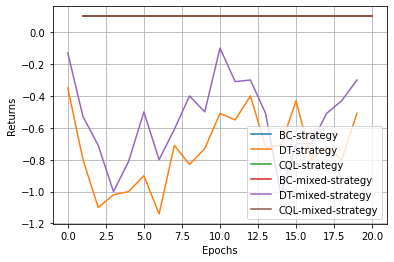

In [38]:
plot_metrics(statistics_bc, "BC-strategy")
plt.plot(dt_statistics[2], label="DT-strategy")
plot_metrics(statistics_cql, "CQL-strategy")
plot_metrics(statistics_bc_mixed, "BC-mixed-strategy")
plt.plot(dt_statistics_mixed[2], label="DT-mixed-strategy")
plot_metrics(statistics_cql_mixed, "CQL-mixed-strategy")
plt.xlabel("Epochs")
plt.ylabel("Returns")
plt.legend()
plt.grid()

# Выводы по offline обучению на смешнанных данных


Добавление 40% рандомных данных в датасет для offline обучения не повлияло на алгоритмы, хотя трансформерная модель стала обучаться даже лучше. Наверное, пропорция не очень существенная рандомных данных. 